# LINMA1702 modèles et méthodes d'optimisation
# Projet 2020-2021 : Logistique de la vaccination en Belgique
### Groupe 6 : Théau Lepouttre, Eliott Van Dieren et Nicolas Mil-Homens Cavaco


In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mip import *

### Hypothèses

On considère une certaine population répartie en $m$ classes d'âge dans $n$ provinces en Belgique.
Parmi les personnes constituant cette population, on distingue deux parties distinctes:

* les personnes susceptibles 
* les autres, c'est-à-dire les malades, les vaccinés, les guéris et les morts.
    
On suppose cette population comme constante dans le temps.
Notre objectif est de minimiser le nombre de morts dû à l'épidémie.

Pour ce faire, on organise une campagne de vaccination qui s'étend sur une durée de $T$ jours et pour laquelle le buget est limité.

#### Journée type
On considère qu'une journée se déroule de la manière suivante:

Tout d'abord, on effectue le bilan de la population susceptible et vaccinable. Il s'agit du nombre de personnes parmi cette population qui n'est pas tombée malade la veille et qui n'a pas été vaccinée. 
Ensuite, les personnes tombent malades au matin, par exemple entre 8h30 et 12h.
Finalement, on vaccine la population restante l'après-midi. Les personnes qui sont tombées malade au matin ne font donc plus partie de la population que l'on peut vacciner.

#### Initialisation de la campagne
Au jour $0$, on dispose d'une certaine population initiale susceptible $p_{init}$. Puisque la campagne de vaccination n'a pas encore commencée, les livraisons et vaccinations ne sont pas possibles. 

La nuit passe et le lendemain matin (jour $1$), une certaine partie de la population tombe malade. 
Certains vaccins sont livrés mais ils ne pourront être utilisés qu'à partir du lendemain.
Dès lors, les vaccinations au jour $1$ sont nulles.

Ensuite, au jour $2$, encore une partie de la population restante tombera malade au matin. Et l'après-midi, nous pourrons commencer les premières vaccinations. Le lendemain, il restera donc la population qui est, ni tombée malade au jour $1$, ni tombée malade au jour $2$ mais également qui ne s'est pas faite vaccinée au jour $2$.


### Question 1.1

#### Modèle

Dans ce premier modèle, on considère le cas d'un seul centre ($n=1$).
En outre, le stockage des vaccins n'est pas autorisé.

Soit les variables suivantes

* $x^t \equiv$ le nombre de doses qui arrivent au centre de vaccination au temps $t$;
* $y_i^t \equiv$ le nombre de doses administrées à la classe d'âge $i$ au temps $t$;
* $(v_s)_i^t \equiv$ le nombre de personnes susceptibles vaccinables parmi les personnes de la classe $i$ au temps $t$.
$(v_s)_i^t$ est considéré comme une variables car il dépend directement du nombre de personnes que l'on vaccine.

On note par $p_{init}$ la population totale initiale de susceptibles et $(n_s)_i^t$ le nombre de personnes susceptibles non-vaccinables parmi les personnes de la classe $i$ au temps $t$. Puisque cette deuxième partie des suscpetibles n'est pas vaccinable, il ne s'agit pas d'une variable de notre problème. Dès lors, minimiser le nombre de morts revient à minimiser le nombre de morts parmi ceux que l'on peut vacciner. 

Soit les paramètres suivants

* $b_c^t \equiv$ le nombre de vaccins livrés dans l'entrepôt central;
* $b_l^t \equiv$ le nombre maximal de vaccins livrés au temps $t$;
* $b_v^t \equiv$ le nombre maximal de vaccins administrés au temps $t$;
* $c_{tr} \equiv$ le coût de transport;
* $c_v \equiv$ le coût de vaccination;
* $c_{tot} \equiv$ le budget total disponible.

Soit

* $\lambda_i^t \equiv$ la fraction parmi les personnes susceptibles tombant malade au jour $t$ pour la classe $i$.
* $\varepsilon_i^t \equiv$ la fraction parmi les personnes de la classe $i$ tombées malades au jour $t$ qui décèderont.
* $\mu_i \equiv$ la fraction de population disposée et autorisée à se faire vacciner.

On identifie les contraintes suivantes, classées en $2$ catégories:
- 1. les contraintes de capacités et de budget:
    * Le budget total de la campagne de vaccination est limité $(1)$.
    * Le nombre de vaccins livrés est limité chaque jour par le nombre de vaccins disponibles dans l'entrepôt central $(2)$.
    * Le nombre de vaccins livrés est limité chaque jour par la limite du centre de vaccination $(3)$.
    * Le nombre de vaccins administrés est limité chaque jour $(4)$.
$$\\ $$
- 2. les contraintes physiques:
    * Le total de vaccins administrés au temps $t$ ne peut pas dépasser le nombre total de vaccins livrés la veille, et ce sur toute la durée de la campagne $(5)$.
    * Seules les personnes disposées et autorisées et qui ne sont pas tombées malade au matin peuvent se faire vacciner  l'après-midi $(6)$.
    * Le nombre de personnes susceptilbes et vaccinables pour une classe $i$ au temps $t$ vaut le nombre de personnes susceptibles et vaccinables la veille auquel on soustrait le nombre de vaccinations et le nombre de malades (parmi les susceptibles vaccinables) la veille $(7)$.


Finalement, on prend la convention que $x^0 = 0$ et $y^0 = 0$, en d'autres termes aucun vaccin n'a été livré et n'a été adminstré la veille du début de la campagne $(9)$. On note également par $(v_s)^0_i$ la population initiale de susceptibles vaccinable $(8)$.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, v_s}& \sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ (v_s)_i^t \\
\sum_{t=1}^T \left(c_{tr}\ x^t + c_v \sum_{i=1}^{m} y_i^t\right) &\leq& c_{tot} \tag{1}\\
x^{t} &\leq & b_c^t  \tag{2}\\  
x^t &\leq& b_l^t \tag{3}\\
\sum_{i=1}^{m} y_i^t &\leq& b_v^t \tag{4}\\
x^{t-1} - \sum_{i=1}^{m} y_i^t &\geq& 0 \tag{5}\\
(1-\lambda_i^{t})\ (v_s)_i^t - y_i^t &\geq&  0\tag{6}\\ 
(v_s)_i^t - \left((1-\lambda_i^{t-1})\ (v_s)_i^{t-1} - y_i^{t-1} \right) &=&  0 \tag{7}\\
(v_s)_i^0 &=& \mu_i\ (p_{init})_i \tag{8}\\ %(n_s)_i^t - (n_{nv})_i^t \\
x^0,\ y^0 &=& 0 \tag{9}\\
x,\ y,\ v_s &\geq& 0 \tag{10}
\end{eqnarray*}$$

Lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$ et $i\in\{1,\ldots,m\}$.

Si l'on veut effectuer le bilan de malades et de morts sur la population globale, c'est-à-dire en prenant en compte la population non-vaccinable, alors on peut calculer $(n_s)_i^t$ comme suit

$$\begin{eqnarray*}
(n_s)_i^t &=& (1-\lambda_i^{t-1})\ (n_s)_i^{t-1} \\
(n_s)_i^0 &=& (1-\mu_i)\ (p_{init})_i
\end{eqnarray*}$$

Le nombre de morts total sera alors égal à 
$$\sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ \left((v_s)_i^t + (n_s)^t_i\right)$$

#### Données du problème

In [160]:
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_tot = 100e6         # budget total autorisé
b_l   = 15e8          # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

# Population initiale
pop_init = np.array([3778123, 2846993, 2790883, 1390502, 111533])

# Fraction de malades
_lambda = lambda t: np.array([0.000298 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000301 * (1/5 + np.sin(t/50)**2),
                               0.000204 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000209 * (1/5 + np.sin(t/50-2/5)**2),
                               0.000329 * (1/5 + np.sin(t/50-2/5)**2)])

# Fraction de morts
_epsilon = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])

mu  = np.array([0.3, 0.6, 0.7, 0.9, 0.9])     # proportion de la population disposée à se faire vacciner.

b_c = np.zeros(T);
days = np.arange(1, T+1)
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]

for t in days-1:
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]

b_c[-1] = b_c_eff[-1] # /!\: à modifier

#lambda_t  = _lambda(days)
#epsilon_t = _epsilon(days)

lambda_t  = [[_lambda(days)[i,t] for i in range(m)] for t in days-1]  + [[0.0]*m]
epsilon_t = _epsilon(days)

In [161]:
def init_variables(model, m, T):
    """
    Initialise les variables x,y,v_s au format: x[t], y[t][i], v_s[t][i].
    @args: 
        model: mip Model: modèle d'optimisation linéaire
        m: int: nombre de classes d'âge
        t: int: durée de la campagne
    @returns:
        x: List[Var]: variables de livraison
        y: List[List[Var]]: variables d'administration des vaccins
        v_s: List[List[Var]]: nombre de susceptibles vaccinables
    """
    x = [model.add_var() for _ in range(T+1)]
    y = model.add_var_tensor((T+1, m), 'y')
    v_s = model.add_var_tensor((T+1, m), 'v_s')
    
    return x, y, v_s

#### Résolution du modèle

Pour l'implémentation en python, on adopte la convention suivante:
- Les variables ont une dimension temporelle de $T+1$.
- Pour une variable $x$, $x[-1]$ désigne la valeur au jour $0$, c'est-à-dire la veille du début de la campagne.

In [162]:
model_I1 = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x, y, v_s = init_variables(model_I1, m, len(days))

# Objectif
model_I1.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i] * v_s[t][i] for i in range(m) for t in days-1))

# Contraintes
model_I1 += xsum(c_tr * x[t] for t in days-1) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot # (1)
for t in days-1:
    model_I1 += x[t] <= b_c[t]                                  # (2)
    model_I1 += x[t] <= b_l                                     # (3)
    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v          # (4)
    model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0   # (5)
        
    for i in range(m):
        model_I1 += (1 - lambda_t[t][i]) * v_s[t][i] -  y[t][i] >= 0                   # (6)
        model_I1 += v_s[t][i] - (1 - lambda_t[t-1][i]) * v_s[t-1][i] + y[t-1][i] == 0  # (7)
        
# Conditions initiales   
model_I1 += x[-1] == 0                                 # (9)
for i in range(m):
    model_I1 += y[-1][i] == 0                          # (9)
    model_I1 += v_s[-1][i] - mu[i] * pop_init[i] == 0  # (8)

model_I1.optimize()
print(f"f(x,y) = {model_I1.objective_value}")

f(x,y) = 1936.5261033590948


In [163]:
# Calcul de la population non-vaccinable
n_s = np.zeros((T+1,m))
n_s[-1] = (1-mu) * pop_init
for t in days-1:
    for i in range(m):
        n_s[t][i] = (1 - lambda_t[t-1][i]) * n_s[t-1][i]

print(f"population morte totale = {model_I1.objective_value + sum(epsilon_t[i][t] * lambda_t[t][i] * n_s[t][i] for i in range(m) for t in days-1)}")

population morte totale = 2519.8929535252582


#### Résultats 

In [164]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [x[t].x for t in days-1]
vaccination = [[y[t][i].x for t in days-1] for i in range(m)]
susceptible = [[(n_s[t][i] + v_s[t][i].x) for t in days-1] for i in range(m)]
pop_s       = [sum((n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]
pop_malade  = [sum( lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]
pop_morte   = [sum(epsilon_t[i][t] * lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]


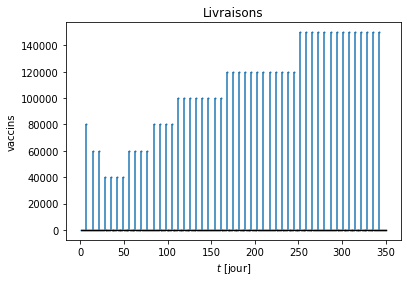

In [165]:
# Plot des livraisons
plt.figure()
plt.title("Livraisons")
markerline, stemlines, baseline = plt.stem(days, livraisons)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()   

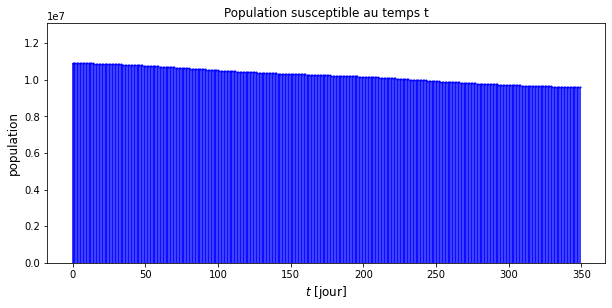

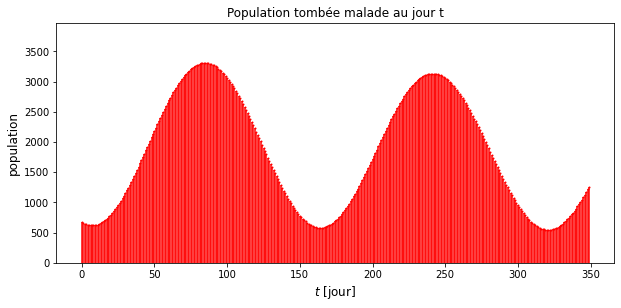

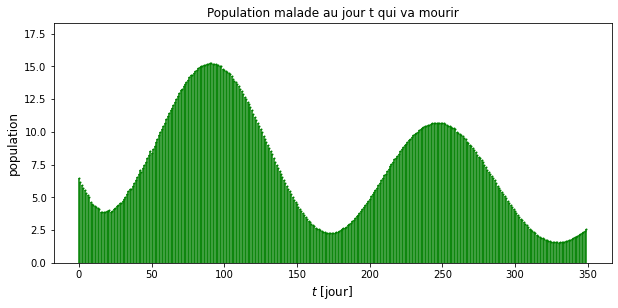

In [166]:
# Plot des populations
pop = [pop_s, pop_malade, pop_morte]
color = ['b','r','g']
titres_pop = ["Population susceptible au temps t", "Population tombée malade au jour t", "Population malade au jour t qui va mourir"]

for i in range(3):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 1, i + 1)
    plt.title(titres_pop[i])
    markerline, stemlines, baseline = plt.stem(days-1, pop[i], "-"+color[i])
    plt.xlabel("$t$ [jour]", fontsize=12)
    plt.ylabel("population", fontsize=12)
    plt.ylim((0, max(pop[i])*1.2))
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_color(color[i])
    markerline.set_markersize(1)
    plt.show()

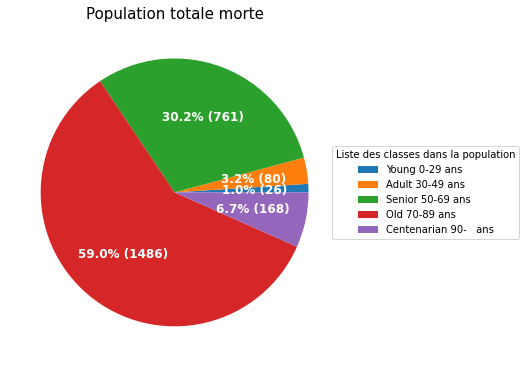

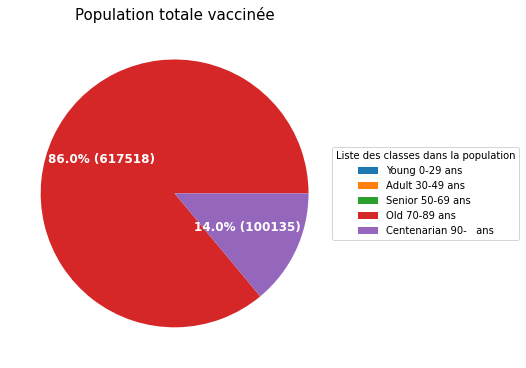

In [167]:
# Sources : fortement inspiré du code à l'adresse :
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

print()
data_pmorte    = [sum(epsilon_t[i][t] * lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for t in days-1) for i in range(m)]
data_pvaccinee = [sum(y[t][i].x for t in days-1) for i in range(m)]
data = [data_pmorte, data_pvaccinee]
titles = ["Population totale morte", "Population totale vaccinée"]

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute) if absolute > 1e-5 else ""


def simpleCamembert(data, titles):
    fig, ax = plt.subplots(figsize=(6, 9), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(d, autopct=lambda pct: func(pct, d),textprops=dict(color="w"))
    
    ax.legend(wedges, population, title="Liste des classes dans la population",
          loc="center",
          bbox_to_anchor=(1, 0, 0.5, 1))


    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title(title, fontsize=15)
    plt.show()

        
for d,title in zip(data, titles):
    simpleCamembert(d, title)

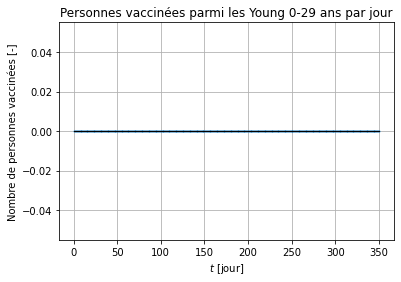

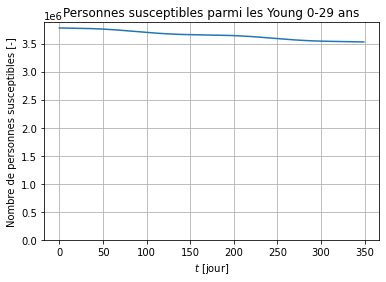

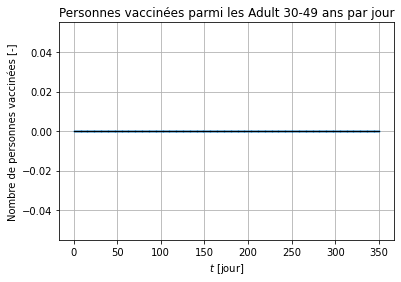

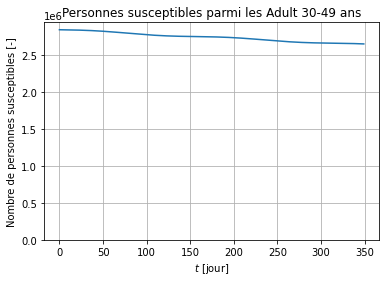

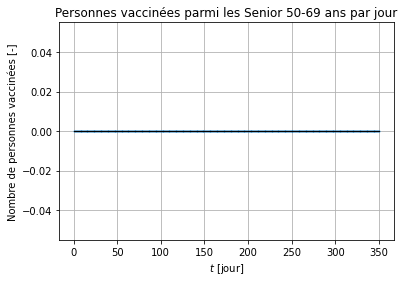

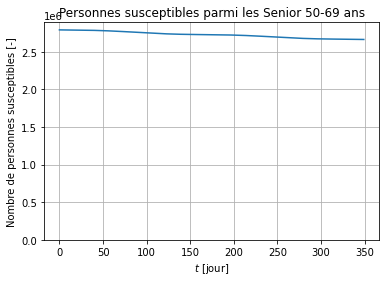

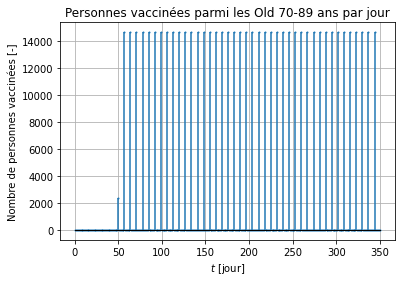

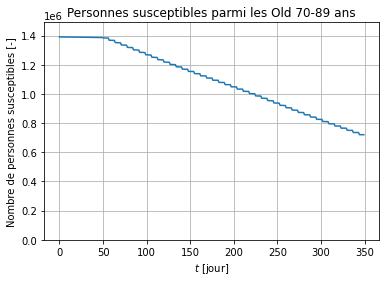

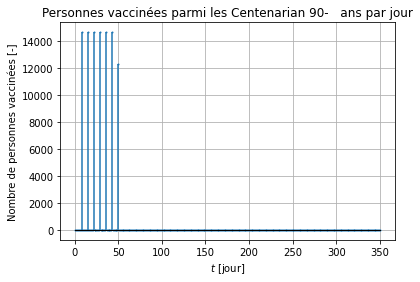

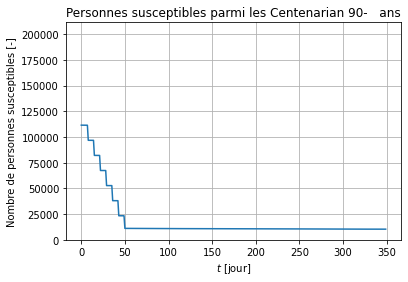

In [168]:
# Titres
titres = [f"{population[i]}" for i in range(m)]

plt.figure("Question 1.1")
for i in range(5):
        plt.title("Personnes vaccinées parmi les " + titres[i] +" par jour")
        markerline, stemlines, baseline = plt.stem(days, vaccination[i])       
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("Nombre de personnes vaccinées [-]", fontsize=10)

        baseline.set_color('k')
        baseline.set_linewidth(1)
        markerline.set_markersize(1)
        plt.grid()
        plt.show()
        
        plt.title("Personnes susceptibles parmi les " + titres[i])
        plt.plot(days-1, susceptible[i])
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("Nombre de personnes susceptibles [-]", fontsize=10)
        plt.ylim((0, max(susceptible[i]) + 1e5))
        plt.grid()
        plt.show()

#### Analyse des résultats obtenus

On remarque que notre programme porte la plus grande importance aux coefficients $\lambda$ (fractions des malades) et $\varepsilon$ (fraction des mourants parmis les malades). Notre objectif étant la minimisation du nombre total de morts, cela fait sens de voir que les classes présentant le plus grand taux d'indidence et de décès, pondérés par la taille de la classe d'âge, soient vaccinées en premier.

De fait, on remarque que ces coefficients sont bien plus élevés pour les groupes que sont les "centenaires" (90+ ans) et les "personnes âgées" (70-89 ans). Malgré une population plus réduite que les autres classes d'âge étudiées, la magnitude de ces coefficients force notre programme à privilégier ces deux classes d'âge.

Nous pouvons également remarquer qu'aucune vaccination des autres classes d'âge n'est prévue puisque les personnes appartenant à ces dernières tombant malades et mourant du virus sont moins nombreuses. Ces personnes-là ne seront donc pas prises en charges d'un point de vue vaccinal et mourront donc au cours de la campagne de vaccination. Le fait que nous ne puissions pas prendre en charge les classes d'âge plus à risque est lié aux contraintes qui nous sont imposées. De fait, on peut remarquer que la contrainte $(1)$ (de coût) n'est pas serrée et que notre modèle est donc contraint par la livraison et l'administration des vaccins aux différentes classes d'âge. Augmenter le budget total est donc inutile mais fournir plus de capacité de vaccination et de transport s'avèrerait utile. 

Comme prévu, la population suceptible de tomber malade diminue bien durant la campagne de vaccination. D'un point de vue des classes d'âge, nous observons une chute de population susceptible pour les classes d'âges visées par la campagne. Les autres populations diminuent également, puisque une certaine fraction tombe malade chaque jour, et quitte donc la catégorie de "susceptible".

Finalement, le stockage n'étant pas mis en place dans cette sous-question, on vaccine la population le lendemain de la livraison des vaccins, ce qui limite la vaccination et la gestion interne aux centres de l'administration des doses de vaccin.

### Question 1.2

#### Modèle

On considère à présent le cas de $n$ provinces. Dans le cas de la Belgique, on aura $n=11$.
On autorise également le stockage des vaccins dans les centres.

Par rapport au modèle précédent, on introduit 
* $z_j^t \equiv$ le nombre de vaccins mis en stock au temps $t$ et disponibles pour le lendemain dans le centre de la province $j$, variable. Ces vaccins ne sont donc pas administrés au jour $t$.
* $(c_s)_j \equiv$ le coût associé au stockage d'un vaccin dans le centre $j$, connu.

Comme pour le point précédent, on impose que les vaccins livrés au jour $t$ ne peuvent être administrés qu'à partir du lendemain (au jour $t+1$). Dans ce modèle, on fait l'hypothèse qu'un vaccin livré au jour $t$ peut être stocké gratuitement jusqu'au lendemain et que l'on ne paye qu'en cas de prolongement sur sa durée de stockage.

Outre les contraintes identifiées plus haut, on ajoute le fait que tous les vaccins qui sont arrivés la veille ou qui étaient en stock la veille peuvent, soit être administrés, soit être mis en stock pour le lendemain $(6)$.
On ajoute également la contrainte sur la capacité de stockage dans chaque province et chaque jour $(5)$.

Finalement, puisqu'on suppose que chaque province $j$ subit l'épidémie de manière indépendante, les contraintes sont propres à chacune d'entres elles, excepté les contraintes de coût total $(1)$ et de vaccins disponibles au hangar central $(2)$.

De manière similaire à la question 1.1, on prend la convention $x^0 = 0$, $y^0 = 0$ et $z^0 = 0$ car aucun vaccin n'a été livré, administré ou mis en stock la veille du début de la campagne $(10)$.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, z, v_s}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
(v_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left((c_{tr})_j\ x_j^t + (c_v)_j \sum_{i=1}^{m} y_{ij}^t + (c_s)_j\ z_j^t\right) &\leq& c_{tot} \tag{1}\\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \tag{2}\\ 
x_j^t &\leq& (b_l)_j^t \tag{3}\\
\sum_{i=1}^{m} y_{ij}^t &\leq& (b_v)_j^t \tag{4}\\
z_j^t &\leq& (b_s)_j^t \tag{5}\\
x_j^{t-1} + z_j^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \tag{6}\\
(1-\lambda_{ij}^{t})\ (v_s)_{ij}^t - y_{ij}^t &\geq& 0\tag{7}\\
(v_s)_{ij}^t - \left((1-\lambda_{ij}^{t-1})\ (v_s)_{ij}^{t-1} - y_{ij}^{t-1} \right) &=&  0 \tag{8}\\
(v_s)_{ij}^0 &=& \mu_i\ (p_{init})_{ij}\tag{9}\\ 
x^0,\ y^0,\ z^0 &=& 0 \tag{10} \\
x,\ y,\ z,\ v_s &\geq& 0 \tag{11}
\end{eqnarray*}$$

A nouveau, lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$, $i\in\{1,\ldots,m\}$ et $j\in\{1,\ldots,n\}$.

De la même manière qu'à la question 1, on peut effectuer le bilan de malades et de morts sur la population globale en calculant la population non-vaccinable:

$$\begin{eqnarray*}
(n_s)_{ij}^t &=& (1-\lambda_{ij}^{t-1})\ (n_s)_{ij}^{t-1} \\
(n_s)_{ij}^0 &=& (1-\mu_i)\ (p_{init})_{ij}
\end{eqnarray*}$$

Le nombre de morts total sera alors égal à 
$$\sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
\left((v_s)_{ij}^t + (n_s)_{ij}^t \right).$$

#### Données du problème

In [169]:
# Fonctions utiles à l'algorithme

def init_variables(model, m, n, T):
    """
    Initialise les variables x,y,z,v_s au format: x[t][j], y[t][j][i], z[t][j], v_s[t][j][i].
    
    @args: 
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
        T: int: durée de la campagne
    
    @returns:
        x: List[List[Var]]: variables de livraison
        y: List[List[List[Var]]]: variables d'administration des vaccins
        z: List[List[Var]]: variables de stockage
        v_s: List[List[List[Var]]]: nombre de susceptibles vaccinables
    """  
    x = model.add_var_tensor((T+1, n), 'x')
    y = model.add_var_tensor((T+1, n, m), 'y')
    z = model.add_var_tensor((T+1, n), 'z')
    v_s = model.add_var_tensor((T+1, n, m), 'v_s')
    
    return x,y,z,v_s

def init_population(m, n):
    """
    Initialise la population de susceptibles au format: pop_init[j][i].
    
    @args: 
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
    
    @returns: 
        pop_init: List[List[int]]: population de susceptibles initiale dans chaque province.
        province: List[String]: noms des provinces.
        tranche: List[String]: noms des tranches
        _lambda: Panda DataFrame: fraction de la population de malade au temps 0.
    """
    Fraction_malade_province = pd.read_csv("Données-v1.2/Fraction_malade_province.csv")
    _lambda = Fraction_malade_province.set_index('Tranche')
    province = _lambda.columns.to_numpy()
    tranche  = _lambda.index.to_numpy()
    
    population_Province = pd.read_csv("Données-v1.2/Population_province.csv")
    population_Province2 = population_Province.set_index('Province')["Population"]
    
    pop_init = np.array([[population_Province2[province[j]][4],
                 population_Province2[province[j]][0],
                 population_Province2[province[j]][3],
                 population_Province2[province[j]][2],
                 population_Province2[province[j]][1]]
                 for j in range(n)])
    
    return pop_init, province, tranche, _lambda

In [170]:
# Données du problème
T_2 = 380             # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
n = 11                # Nombre de provinces
days_2 = np.arange(1, T_2+1)

# Initialision de la population
pop_init, province, tranche, _lambda = init_population(m, n); print(f"tranche = {tranche}\nprovince = {province}")

# Initialisation de la fraction de malade au format lambda_t[t][i][j]
lambda_t = [[
    [_lambda[province[j]][tranche[0]]  * (1/5 + np.sin(t/50-1/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[1]]  * (1/5 + np.sin(t/50)**2)     for j in range(n)],
    [_lambda[province[j]][tranche[2]]  * (1/5 + np.sin(t/50-1/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[3]]  * (1/5 + np.sin(t/50-2/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[4]]  * (1/5 + np.sin(t/50-2/5)**2) for j in range(n)]] for t in days_2-1] \
  + [np.zeros((m,n))]

# Initialisation de la fraction de morts au format _epsilon[t][i]
_epsilon  = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])
epsilon_t = _epsilon(days_2)

# Initialisation de la fraction de personnes vaccinables
mu = np.array([0.3, 0.6, 0.7, 0.9, 0.9])

# Initialisation des contraintes
constr = pd.read_csv("Données-v1.2/Centres_vaccination.csv")
constr = constr.set_index('Province')

c_tot = 100e6                                                          # budget total autorisé
c_tr  = [constr['CoutTransport'][province[j]] for j in range(n)]       # Prix de livraison d'un vaccin
c_v   = [constr['CoutDose'][province[j]] for j in range(n)]            # prix d'administration d'un vaccin
c_s   = [constr['CoutStockage'][province[j]] for j in range(n)]        # Coût de stockage
b_l   = [constr['CapaciteTransport'][province[j]] for j in range(n)]   # nombre maximal de vaccins livrés par jour
b_v   = [constr['CapaciteVaccination'][province[j]] for j in range(n)] # nombre maximal de vaccins administrés par jour
b_s   = [constr['CapaciteStockage'][province[j]] for j in range(n)]    # nombre de vaccins stockables

# Vaccins livrés au hangar central
b_c = np.zeros(350);
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]
for t in np.arange(350):
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]
        
b_c[-1] = b_c_eff[-1]

# On prolonge la longueur de b_c de 30 jours
b_c = np.concatenate((b_c, np.zeros(30)))

tranche = ['young' 'adult' 'senior' 'old' 'centanarian']
province = ['Province de Flandre orientale' 'Province de Flandre occidentale'
 'Province du Brabant flamand' 'Province d’Anvers' 'Province du Hainaut'
 'Province de Liège' 'Province du Limbourg' 'Province du Luxembourg'
 'Province du Brabant wallon' 'Province de Namur' 'Bruxelles']


#### Résolution du modèle

In [171]:
def solve_model(APO_modif='None', modif=None, mod='pm'):
    """
    Résout le modèle d'optimisation linéaire pour n=11 centres.
    Possibilité de vérifier l'analyse post-optimale avec APO_modif.
    
    @args:
        APO_modif: String: modification sur une contrainte de capacité: b_c, b_l, b_v ou b_s.
        modif: numpy array: Valeurs des modifications faites.
        mod: String: désigne le modèle choisi. 'pm': vaccination l'après-midi et 'am': vaccination le matin.
        
    @returns:
        model_I2: mip model
        x: var_tensor: variable de transport
        y: var_tensor: variable de vaccination
        z: var_tensor: variable de stockage
        v_s: var_tensor: population susceptible et vaccinable
    """
    
    # Création du modèle
    model_I2 = Model('multi-centre', sense=MINIMIZE, solver_name=CBC)
    model_I2.clear() # On clear pour être sûr que le modèle soit réinitialisé comme il faut

    # Initialisation des variables
    x,y,z,v_s = init_variables(model_I2, m, n, T_2)
    
    # Objectif
    model_I2.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i][j] * v_s[t][j][i]
                                    for j in range(n) for i in range(m) for t in range(len(days_2))))

    # Contrainte sur le coût total
    model_I2 += xsum(c_tr[j] * x[t][j] for j in range(n) for t in days_2-1) \
             + xsum(c_v[j] * y[t][j][i] for i in range(m) for j in range(n) for t in days_2-1) \
             + xsum(c_s[j] * z[t][j] for j in range(n) for t in days_2-1) <= c_tot      # (1)

    # Contrainte sur la quantité de vaccins livrables au temps t à tous les centres
    for t in days_2-1: 
        if APO_modif == 'b_c':
            model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t] + modif[t]           
        else:
            model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t]                       # (2)

    # Contrainte sur le nombre de vaccins livrables au centre j et au temps t    
    for t in days_2-1:       
        for j in range(n):  
            if APO_modif == 'b_l':
                model_I2 += x[t][j] <= b_l[j] + modif[j][t] 
            else:
                model_I2 += x[t][j] <= b_l[j]                                           # (3)

    # Contrainte sur le nombre de vaccins administrables au temps t    
    for t in days_2-1:       
        for j in range(n):
            if APO_modif == 'b_v':
                model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v[j] + modif[j][t]
            else:
                model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v[j]                # (4)

    # Contrainte sur le nombre de vaccins stockables au centre j et au temps t    
    for t in days_2-1:       
        for j in range(n):   
            if APO_modif == 'b_s':
                model_I2 += z[t][j] <= b_s[j] + modif[j][t]
            else:
                model_I2 += z[t][j] <= b_s[j]                                           # (5)

    # Contrainte physique sur la quantité de vaccins disponibles et stockables au temps t     
    for t in days_2-1:
        for j in range(n):
            model_I2 += x[t-1][j] + z[t-1][j] - xsum(y[t][j][i] for i in range(m)) - z[t][j] >= 0  # (6)

    # Contrainte sur le nombre de personnes vaccinables au temps t        
    for t in days_2-1:          
        for j in range(n): 
            for i in range(m):
                if mod == 'pm':
                    model_I2 += (1 - lambda_t[t][i][j]) * v_s[t][j][i] - y[t][j][i] >= 0  # (7)
                    model_I2 += v_s[t][j][i] - (1 - lambda_t[t-1][i][j]) * v_s[t-1][j][i] + y[t][j][i] == 0  # (8) 
                else:
                    model_I2 += (1 - lambda_t[t][i][j]) * v_s[t][j][i] - y[t][j][i] >= 0  # (7)
                    model_I2 += v_s[t][j][i] - (1 - lambda_t[t-1][i][j]) * v_s[t-1][j][i] + y[t][j][i] == 0  # (8)
                    
    # Conditions initiales
    for j in range(n):   
        model_I2 += z[-1][j] == 0  # (10)
        model_I2 += x[-1][j] == 0  # (10)
        for i in range(m):
            model_I2 += y[-1][j][i] == 0  # (10)
            model_I2 += v_s[-1][j][i] == mu[i] * pop_init[j][i]  # (9)

    print(model_I2.optimize())
    print(f"f(x,y,z) = {model_I2.objective_value}")
    return model_I2, x, y, z, v_s

model_I2, x, y, z, v_s = solve_model()

OptimizationStatus.OPTIMAL
f(x,y,z) = 658.6960938289186


In [172]:
# Caclul de la population non-vaccinable
n_s = np.zeros((T_2+1, n, m))

# Population initiale
for j in range(n): 
    n_s[-1][j] = (1-mu) * pop_init[j]
    
for t in days_2-1:          
    for j in range(n): 
        for i in range(m):
            n_s[t][j][i] = (1 - lambda_t[t-1][i][j]) * n_s[t-1][j][i]

print(f"population morte totale = {model_I2.objective_value + sum(epsilon_t[i][t] * lambda_t[t][i][j] * n_s[t][j][i] for i in range(m) for j in range(n) for t in days_2-1)}")

population morte totale = 1148.8712366271704


#### Résultats 

In [173]:
populationNames  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [[x[t][j].x for t in days_2-1] for j in range(n)]
SommeL      = [sum(livraisons[j][t] for t in days_2-1) for j in range(n)]
vaccination = [[sum(y[t][j][i].x for j in range(n)) for t in days_2-1] for i in range(m)]
SommeV      = [sum(y[t][j][i].x for j in range(n) for t in days_2-1) for i in range(m)]
SommeR      = [sum(y[t][j][i].x for i in range(m) for t in days_2-1) for j in range(n)]
stockage    = [[z[t][j].x for t in days_2-1] for j in range(n)]

population = [sum((v_s[t][j][i].x + n_s[t][j][i]) for j in range(n) for i in range(m)) for t in days_2-1]
population_classe = [[sum((v_s[t][j][i].x + n_s[t][j][i]) for j in range(n)) for i in range(m)] for t in days_2-1]
pop_morte  = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for i in range(m) for j in range(n)) for t in days_2-1]
SommeMC    = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for t in days_2-1 for j in range(n)) for i in range(m)]
SommeMR    = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for t in days_2-1 for i in range(m)) for j in range(n)]

colors = np.array(["red","steelblue","yellow","springgreen","cyan","magenta","darkseagreen","tomato","orange","violet", "green"])
C_tot = sum(c_tr[j] * x[t][j].x for j in range(n) for t in days_2-1) \
+ sum(c_v[j] * y[t][j][i].x for i in range(m) for j in range(n) for t in days_2-1) \
+ sum(c_s[j] * z[t][j].x for j in range(n) for t in days_2-1)
print(f"C_tot = {C_tot}")

C_tot = 89351815.88903902


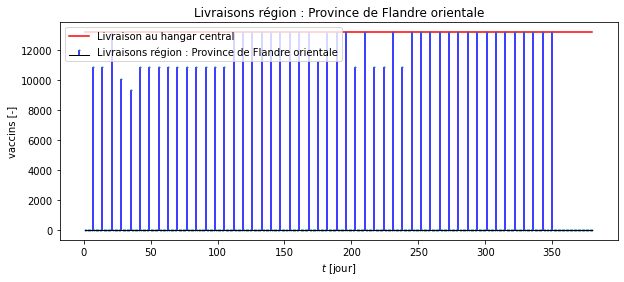

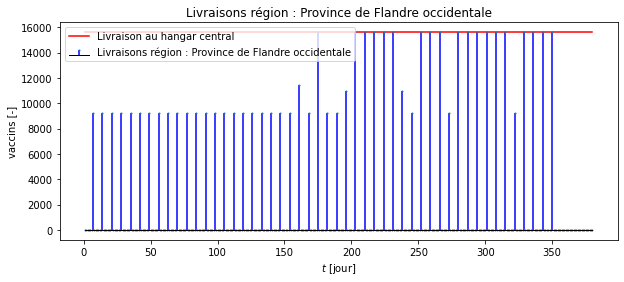

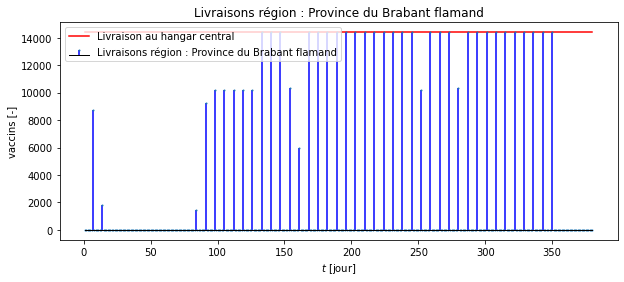

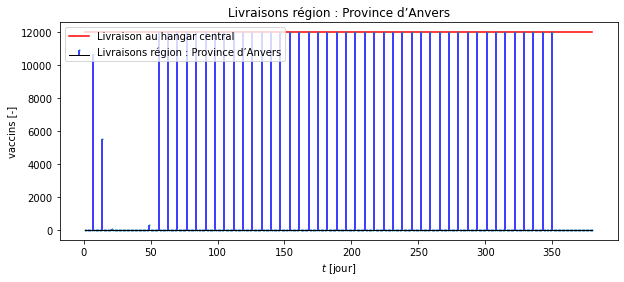

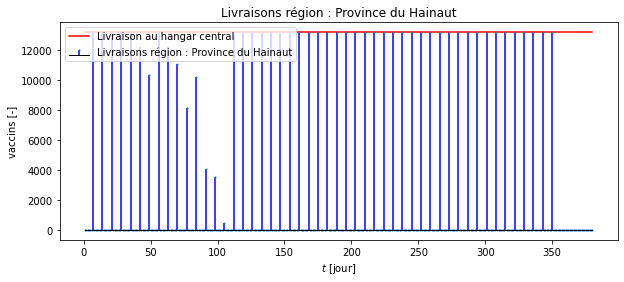

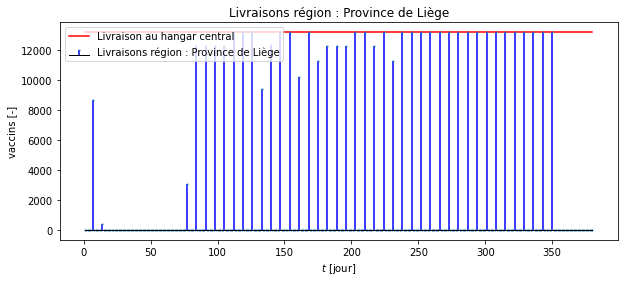

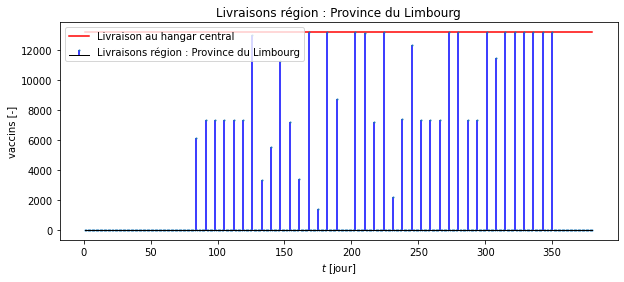

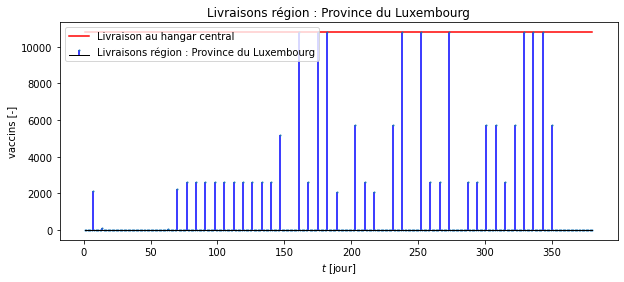

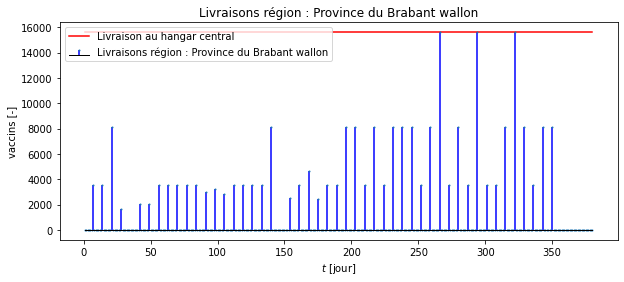

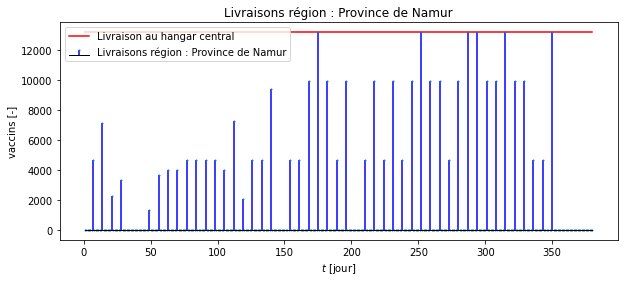

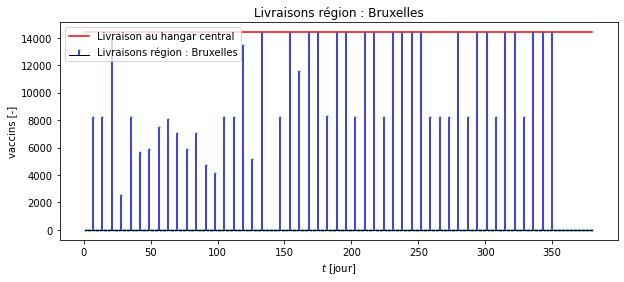

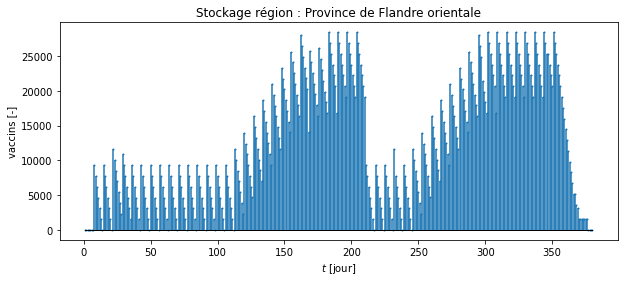

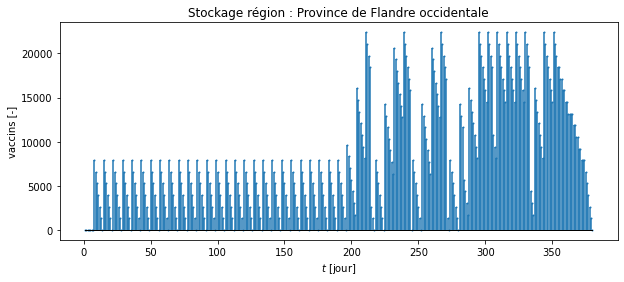

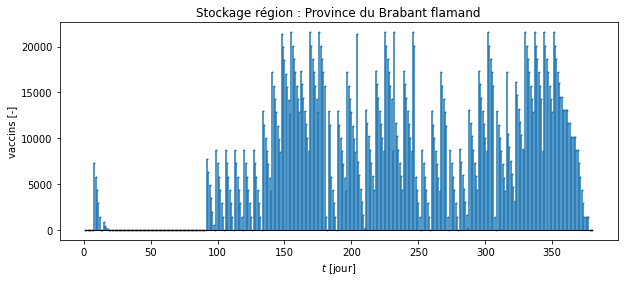

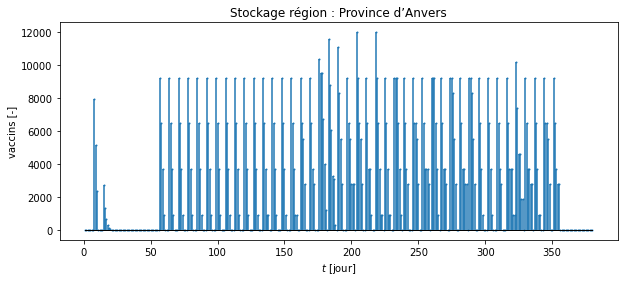

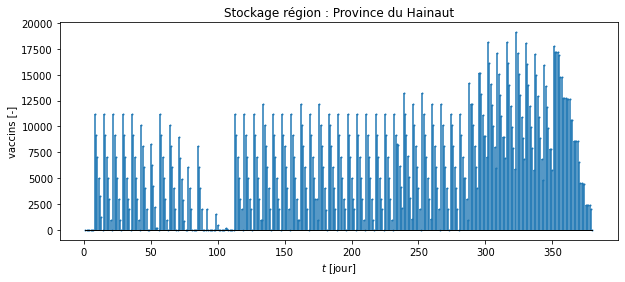

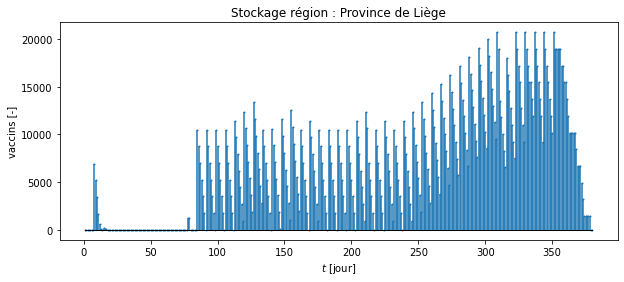

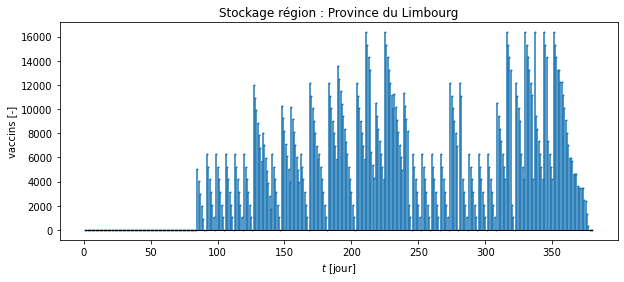

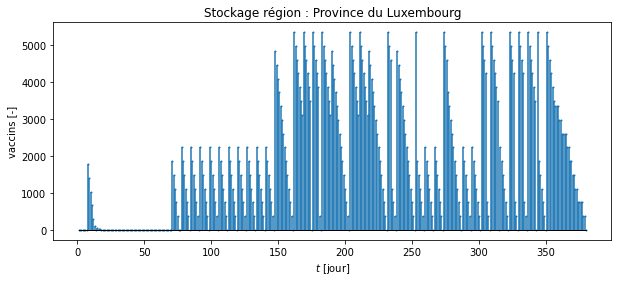

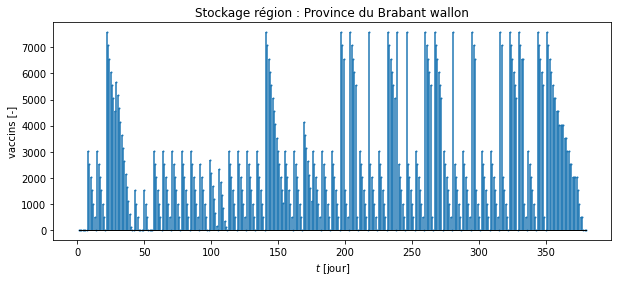

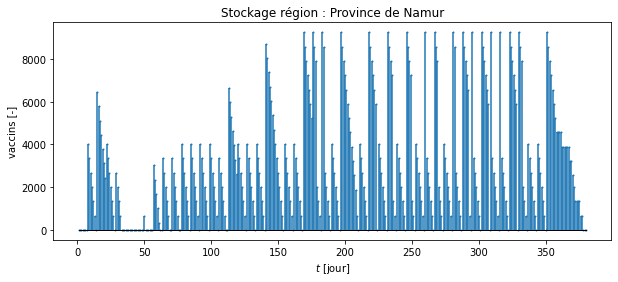

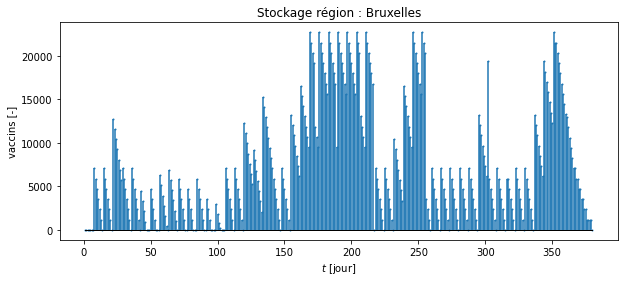

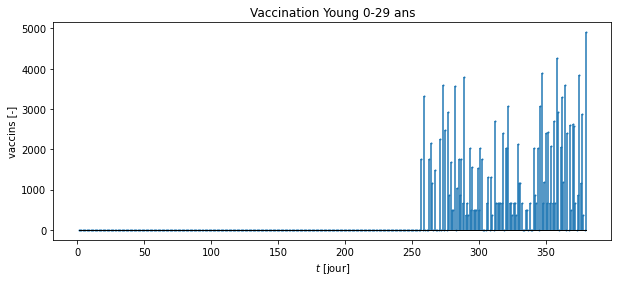

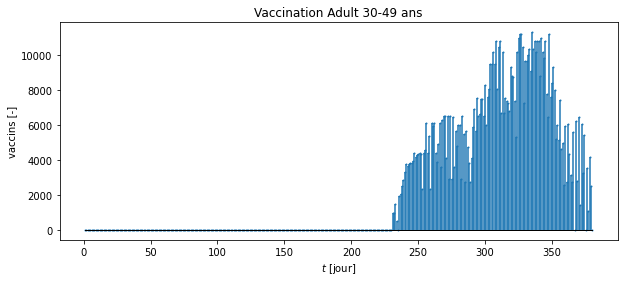

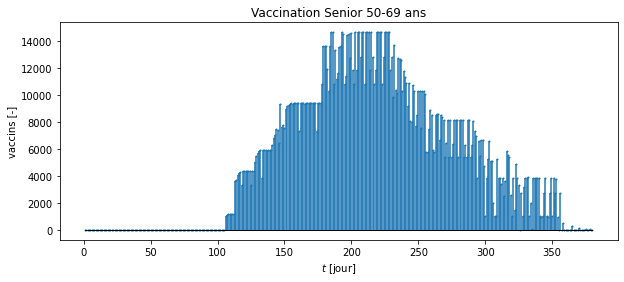

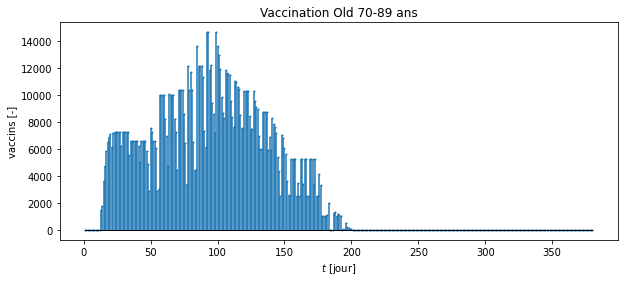

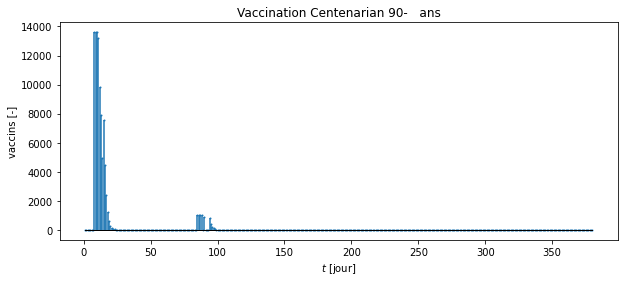

In [174]:
def plot_data(t, data, title, fig="",figsize=(10,4)):
    plt.figure(fig, figsize)
    plt.title(title)
    markerline, stemlines, baseline = plt.stem(t, data)
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins [-]", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()
    
    
def plot_bilan(t, data, title, *constr, constr_name=[], linestyle=[], label_loc=None, figsize=(10,4)):
    plt.figure(figsize=figsize)
    plt.title(title)
    for i in range(len(constr_name)):
        plt.plot(t, constr[i], colors[i % len(colors)], linestyle=linestyle[i], label=constr_name[i])
        
    markerline, stemlines, baseline = plt.stem(t, data, "b", label=title)
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins [-]", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.legend(loc=label_loc)
    plt.show()
    
# Plot des livraisons
for j in range(n): 
    plot_bilan(days_2, livraisons[:][j], f"Livraisons région : {province[j]}",
               np.ones_like(days_2)*b_l[j],
               linestyle=['solid'], 
               constr_name=["Livraison au hangar central"],
               label_loc='upper left')
    
# Plot des stockages
for j in range(n): 
    plot_data(days_2, stockage[:][j], f"Stockage région : {province[j]}")
    
# Plot des vaccinations
for i in range(m): 
    plot_data(days_2, vaccination[:][i], f"Vaccination {populationNames[i]}")

**TODO : Commentaires Plots ci-dessus**

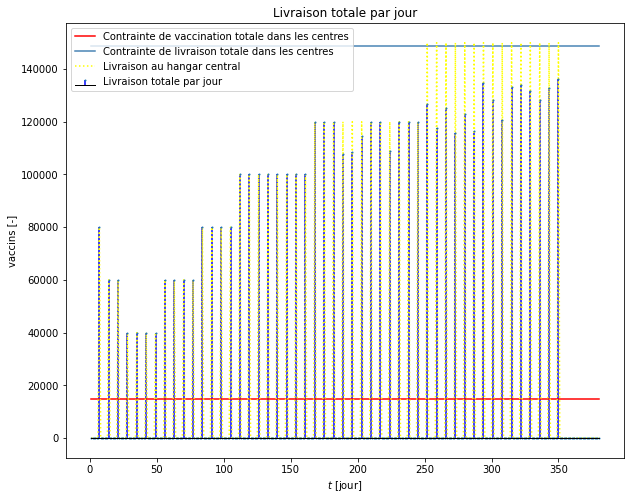

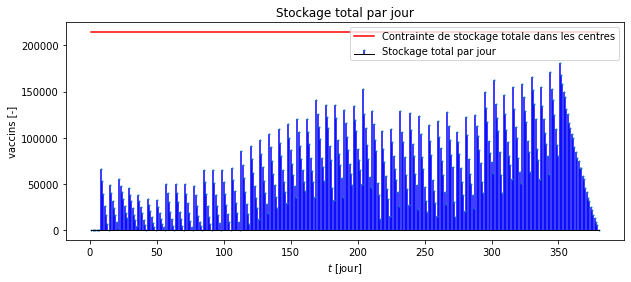

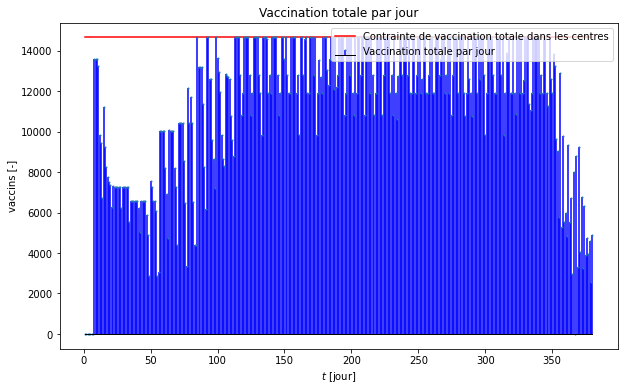

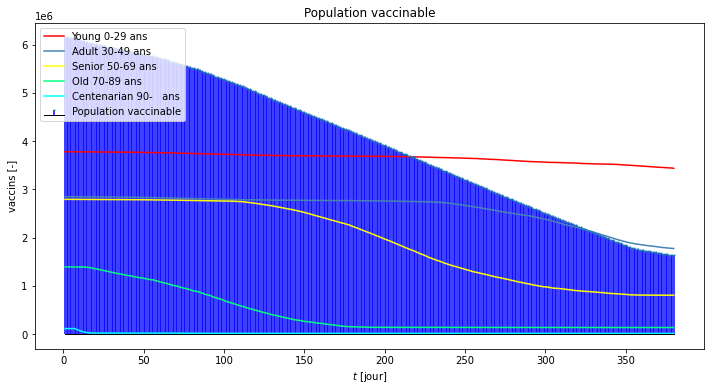

In [175]:
bilan_livraisons   = [sum(x[t][j].x for j in range(n)) for t in days_2-1]
bilan_stockage     = [sum(z[t][j].x for j in range(n)) for t in days_2-1]
bilan_vaccinations = [sum(y[t][j][i].x for j in range(n) for i in range(m)) for t in days_2-1]
population_vaccinable = [sum(v_s[t][j][i].x for j in range(n) for i in range(m)) for t in days_2-1]
    
plot_bilan(days_2, bilan_livraisons, "Livraison totale par jour", 
           np.ones_like(days_2)*sum(b_v), np.ones_like(days_2)*sum(b_l), b_c, 
           linestyle=['solid', 'solid', 'dotted', 'solid'], 
           constr_name=["Contrainte de vaccination totale dans les centres", "Contrainte de livraison totale dans les centres", 
                        "Livraison au hangar central"],
           label_loc='upper left', figsize=(10,8))

plot_bilan(days_2, bilan_stockage, "Stockage total par jour", np.ones_like(days_2)*sum(b_s), 
           linestyle=['solid'], constr_name=["Contrainte de stockage totale dans les centres"], label_loc='upper right')

plot_bilan(days_2, bilan_vaccinations, "Vaccination totale par jour", np.ones_like(days_2)*sum(b_v)
           , linestyle=['solid'], constr_name=["Contrainte de vaccination totale dans les centres"], 
           label_loc='upper right', figsize=(10,6))

plot_bilan(days_2, population_vaccinable, "Population vaccinable",
           [population_classe[t][0] for t in days_2-1],
           [population_classe[t][1] for t in days_2-1],
           [population_classe[t][2] for t in days_2-1],
           [population_classe[t][3] for t in days_2-1],
           [population_classe[t][4] for t in days_2-1],
           linestyle=['solid', 'solid', 'solid', 'solid', 'solid'],
           constr_name=populationNames,
           label_loc='upper left', figsize=(12,6))

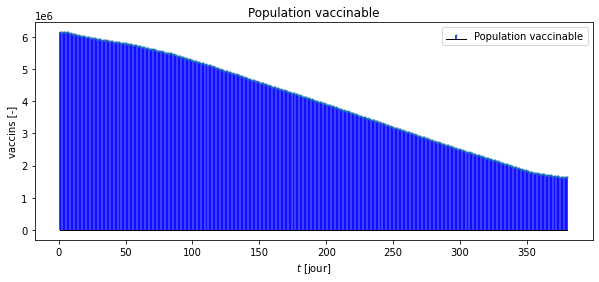

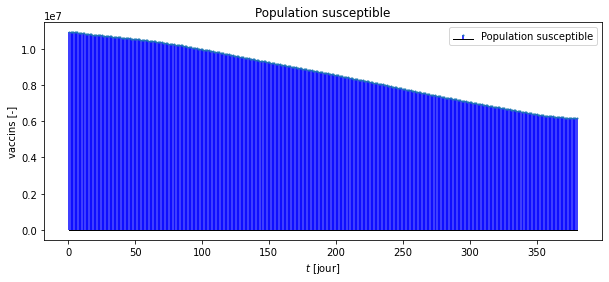

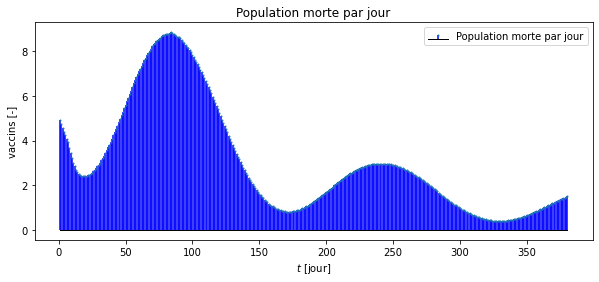

In [176]:
plot_bilan(days_2, population_vaccinable, "Population vaccinable")
plot_bilan(days_2, population, "Population susceptible")
plot_bilan(days_2, pop_morte, "Population morte par jour")

**TODO : Commentaires Plots ci-dessus**

In [177]:
# Plot des livraisons
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct)

def circle(data,labels,name,namePlot):
    fig, ax = plt.subplots(figsize=(6, 9), subplot_kw=dict(aspect="equal"))
    wedges, texts , autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.35), pctdistance=0.825, autopct=lambda pct: func(pct, SommeL), startangle= 45, textprops=dict(color="k"))

    ax.legend(wedges, labels, loc="center", title=f"Liste des {name}", bbox_to_anchor=(1.4, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    ax.set_title(namePlot, fontsize=15)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(float(f"{data[i]:.1f}"), xy=(x, y), xytext=(1.3*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.show()

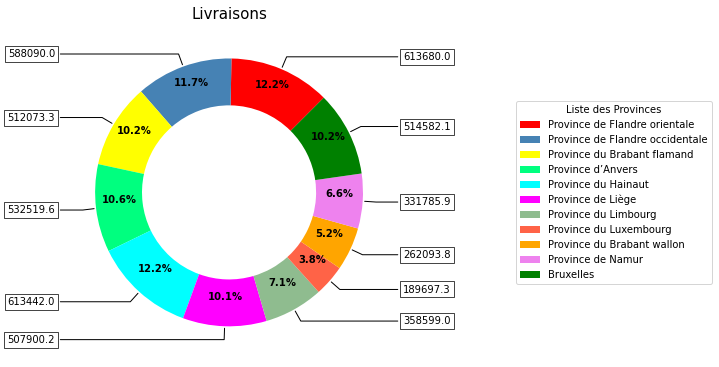

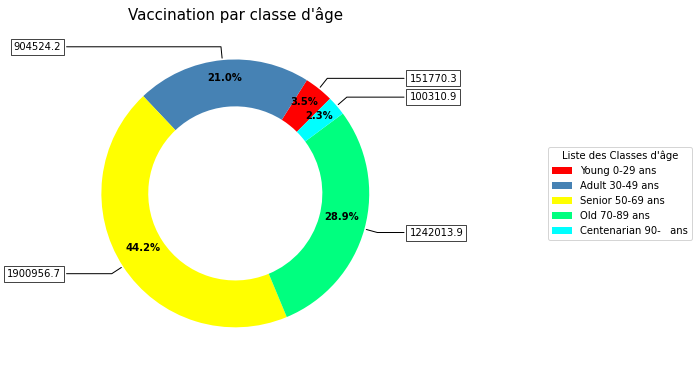

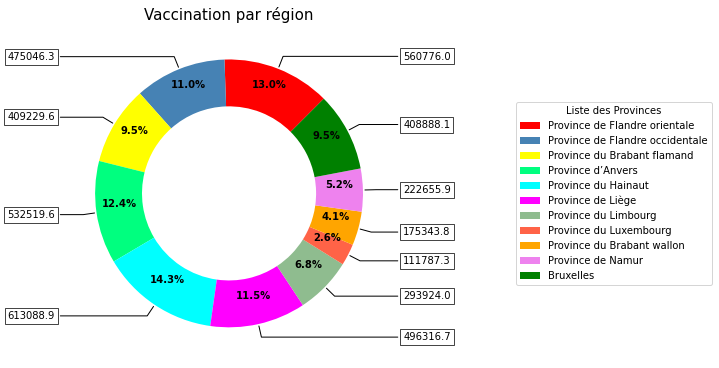

In [178]:
circle(SommeL,province,"Provinces","Livraisons")
circle(SommeV,populationNames,"Classes d'âge","Vaccination par classe d'âge")
circle(SommeR,province,"Provinces","Vaccination par région")

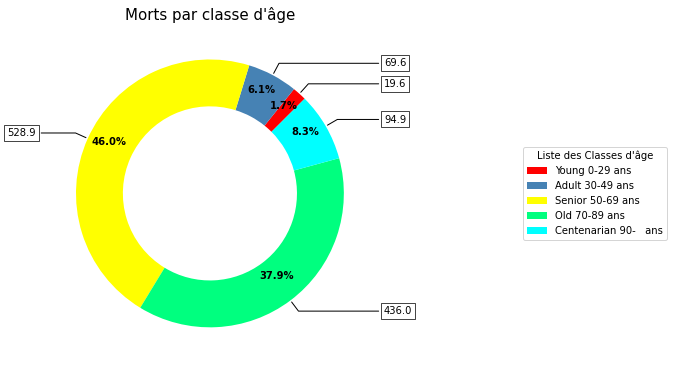

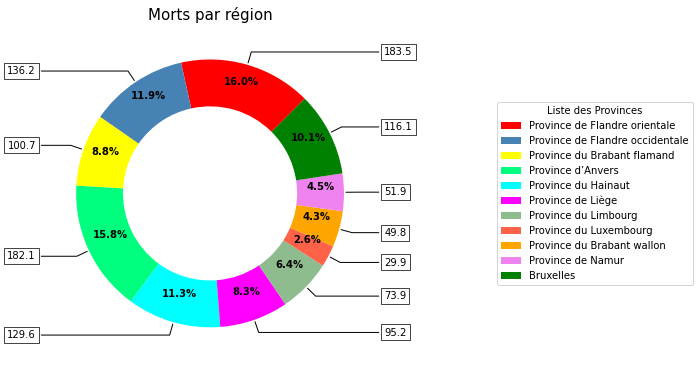

In [179]:
circle(SommeMC,populationNames,"Classes d'âge","Morts par classe d'âge")
circle(SommeMR,province,"Provinces","Morts par région")

**TODO : Commentaires Général sur la question**

#### Analyse des résultats obtenus

TODO - Théau

### Question 1.3$^1$
Pour estimer l'impact de la variation d'une contrainte sur la fonction objectif, on considère la solution du problème dual que l'on note $y_*$. D'après le cours théorique, nous savons que pour une variation $\Delta b$ du vecteur des contraintes $b$, la valeur de la fonction objectif

$$z = y_*^T b\ ,$$
sera modifiée d'une valeur
$$\\ \Delta z = y_*^T \Delta b\ .$$


<sup>1</sup> Pour cette question, le symbole $^T$ signifie la transposée.

In [180]:
y_star = np.array([contrainte.pi for contrainte in model_I2.constrs])
y_star[np.absolute(y_star) < 1e-9] = 0
print(f"y_star = {y_star}")

# Sauvegarde des valeurs dans un fichier
with open("y_star.txt", 'w') as f:
    for i in y_star:
        f.write(str(i) + "\n")

y_star = [ 0.         -0.00094098 -0.00090405 ...  0.00059176  0.
  0.00077955]


#### (a) 
Pour une variation $\Delta c_{tot}$ du budget total, $\Delta b = (\Delta c_{tot},\ 0,\ 0,\ \cdots,\ 0)$
puisqu'il s'agit de notre première contrainte.

In [181]:
# APO = Analyse post optimale

def APO_c_tot(beta):
    delta_b = np.zeros_like(y_star)
    delta_b[0] = beta * c_tot
    delta_z = y_star @ delta_b
    print(f"  {beta:.3f} | {delta_z:.2f}")

print("  {:^6}| {}".format("beta", "Delta z"))
print("  ---------------")
for beta in [1e-3, 5e-3, 1e-2, 1.2]:
    APO_c_tot(beta)

   beta | Delta z
  ---------------
  0.001 | 0.00
  0.005 | 0.00
  0.010 | 0.00
  1.200 | 0.00


On observe que pour toute valeur de $\beta$, même $>1$, la variation de l'objectif $\Delta z$ est identiquement nulle. 
En effet, la contrainte de budget total n'étant pas active, la composante de la solution du dual associée à cette contrainte sera nulle par la relation d'exclusion. Dès lors, pour toute modification suffisamment faible $\Delta c_{tot}$ du budget total, $\Delta z$ sera nul.

#### (b)
On souhaite à présent déterminer la modification sur la quantité de vaccins disponible nécessaire pour diminuer d'une personne le nombre de morts. On note par $\Delta b_c$ le vecteur des modifications sur les quantités disponibles, de même taille que $b_c$. On souhaite donc trouver $\Delta b$ tel que 

$$y_*^T \Delta b = a^T \Delta b_c = -1$$

où $\Delta b_c$ correspond aux composantes non nulles de $\Delta b$ et $a$ est le vecteur des composantes de $y_*$ associées à $\Delta b_c$.

On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens de la norme $1$ (ou de la norme $\infty$). En outre, on impose que $\Delta b$ reste suffisamment faible par rapport à $b$. Le problème s'écrit 

$$\begin{eqnarray*}
& min_{\ t,\Delta b_c} &\ t &\\
a^T \Delta b_c + 1 & \ge & -t \\
a^T \Delta b_c + 1 & \leq & t \\
(\Delta b_c)_k & \leq & \beta\ b_c^k \qquad \forall k, \quad \beta < 1
\end{eqnarray*}$$



$$%OLD VERSION$$
$$%On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens des moindres carrés de la manière suivante:
%A^T A x = A^T u
%avec
%A = \begin{pmatrix}
%  &   &   &   & y_*^T &        &   &   \\
%1 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0 & 0 \\
%\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 1 \\
%\end{pmatrix}; \qquad u =  \begin{pmatrix} -1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}; \qquad x = \Delta b$$


In [182]:
def approx_delta(a, b, beta):
    """ 
    minimisation de la valeur absolue des résidus
        min |a^T x + 1| sc x <= beta * b
    """
    model = Model('residus', sense=MINIMIZE)
    delta_b = np.array([model.add_var() for _ in range(len(a))])
    t = model.add_var()
    model.objective = minimize(t)

    model += xsum(a * delta_b) + 1 + t >= 0
    model += xsum(a * delta_b) + 1 - t <= 0

    for i in range(len(delta_b)):
        model += delta_b[i] <= beta * b[i]

    model.optimize()
    return model, delta_b

Variation du nombre de vaccins disponbibles dans le hangar central par jour pour diminuer d'un mort

Delta z = -1.00


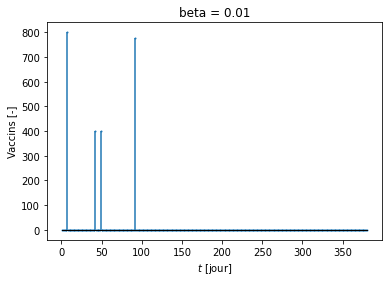

Delta z = -1.00


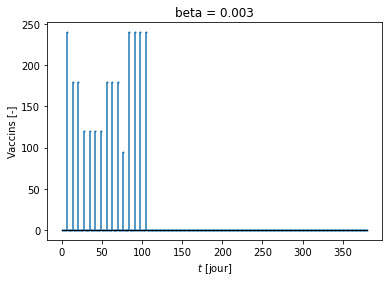

Delta z = -0.03


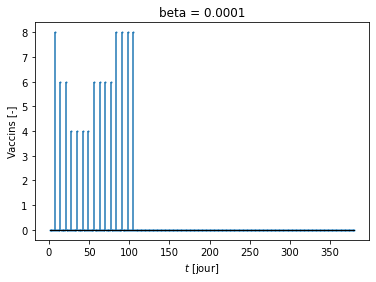

In [183]:
# Résolution du problème
def APO_b_c(tol):
    a = y_star[1:len(b_c)+1]
    q13_b, delta_b_c = approx_delta(a, b_c, tol)

    delta = np.array([delta_b_c[i].x for i in range(len(delta_b_c))])
    #print(delta)
    print(f"Delta z = {a @ delta:.2f}")

    plt.figure()
    plt.title(f"beta = {tol}")
    markerline, stemlines, baseline = plt.stem(days_2, delta)
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("Vaccins [-]", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()  
    
    q13_b.write(f"test b_c {tol}.sol")
    return delta

print("Variation du nombre de vaccins disponbibles dans le hangar central par jour pour diminuer d'un mort\n")
for beta in [1e-2, 3e-3, 1e-4]:   
    APO_b_c(beta)

On peut vérifier que nous diminuons bien de $1$ le nombre de morts en résolvant notre modèle avec cette modification.
On observe une légère différence par rapport à la valeur prédite grâce à la solution du dual, car $y_*^T \Delta b$ donne seulement une valeur approchée sur la modification de la valeur de l'objectif.

Delta z = -1.00


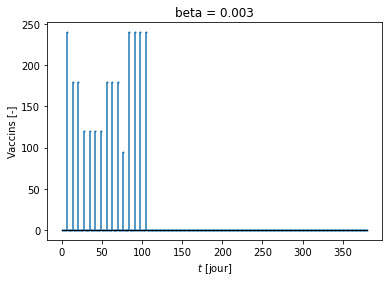

OptimizationStatus.OPTIMAL
f(x,y,z) = 657.6564268224834

valeur initiale de l'objectif : 658.6960938289186


In [184]:
solve_model(APO_modif='b_c', modif=APO_b_c(3e-3))
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

#### Analyse des résultats ATTENTION PHRASE NON FINIE

La solution obtenue, après résolution du problème de minimisation des résidus, nous indique qu'il est possible de diminuer de $1$ le nombre de morts si l'on rend disponible une certaine quantité de vaccins lors des $105$ premiers jours de la campagne. On observe que c'est toujours le cas pour différentes valeurs de $\beta$. 

On observe sur le graphe ci-dessous que la contrainte de 
$$%Si l'on analyse le vecteur $a$ (défini plus haut), on peut remarquer que ses premières composantes auront une valeur plus élevées que ses dernières composantes. Cela signifie que rendre disponible les vaccins au hangar central en début de campagne aura un impact plus élevé sur les vaccinations (i.e l'objectif) que s'ils étaient rendus disponibles en fin de campagne. Cela nous semble logique dans la mesure où la contrainte de coût n'est pas active. En effet, dans ce cas, tout vaccin livré pourra être stocké dans un centre et être utilisé au moment qui convient le mieux.$$

#### (c) 
On estime l'impact d'une modification sur les contraintes de capacités et de coût de manière similaire au point (b). On remplace donc dans l'énoncé précédent $\Delta b_c$ successivement par $\Delta b_v$ le vecteur des modifications sur les vaccins administrables et $\Delta b_l$ le vecteur des modifications sur les vaccins livrables.


Variation du nombre de vaccins administrables dans chaque région et par jour pour diminuer d'un mort:

Delta z = -0.06
beta = 0.001


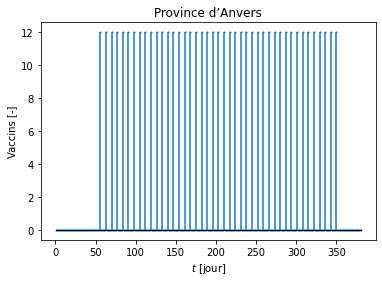

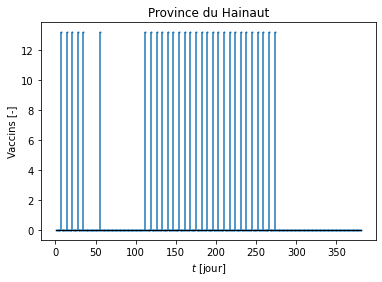

Delta z = -1.00
beta = 0.02


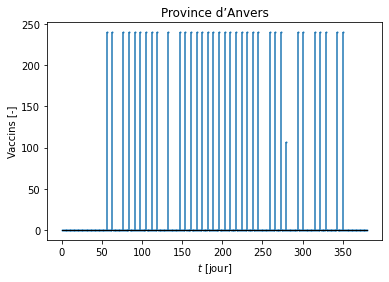

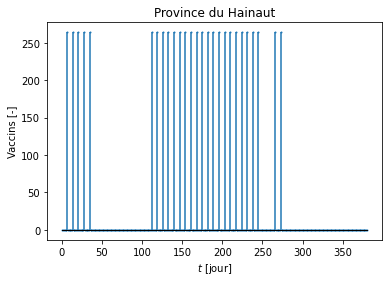

Delta z = -1.00
beta = 0.05


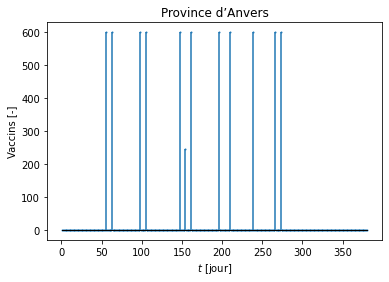

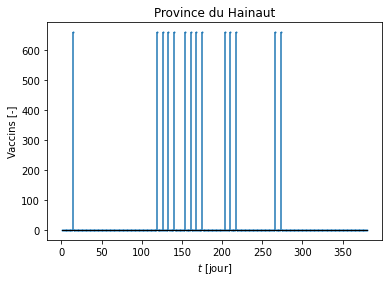

In [185]:
def APO_b_l(beta):    
    b1 = [b_l[j] for t in days_2-1 for j in range(n)]
    a1 = y_star[len(b_c)+1:len(b_c)+len(b1)+1]

    q13_c1, delta_b_l = approx_delta(a1, b1, beta)

    delta_bl = np.array([[delta_b_l[j+t*n].x for t in days_2-1] for j in range(n)])
    delta1 = np.array([delta_b_l[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a1 @ delta1:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bl[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bl[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()  

    return delta_bl

print("\nVariation du nombre de vaccins administrables dans chaque région et par jour pour diminuer d'un mort:\n")
for beta in [1e-3, 2e-2, 5e-2]:
    APO_b_l(beta)

Delta z = -1.00
beta = 0.02


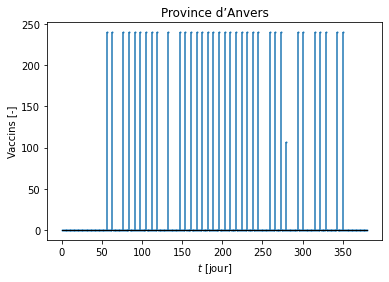

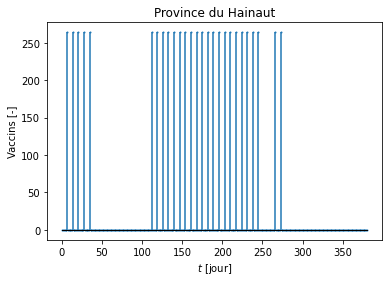

OptimizationStatus.OPTIMAL
f(x,y,z) = 657.8307193584657

valeur initiale de l'objectif : 658.6960938289186


In [186]:
# Vérification
solve_model(APO_modif='b_l', modif=APO_b_l(2e-2))
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

In [187]:
# modification du nombre de vaccins administrables par jour dans chaque centre.
def APO_b_v(beta):
    b2 = [b_v[j] for t in days_2-1 for j in range(n)]
    a2 = y_star[len(b_c)+len(b2)+1:len(b_c)+2*len(b2)+1]

    q13_c2, delta_b_v = approx_delta(a2, b2, beta)

    delta_bv = np.array([[delta_b_v[j+t*n].x for t in days_2-1] for j in range(n)])
    delta2 = np.array([delta_b_v[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a2 @ delta2:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bv[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bv[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()
    
    return delta_bv


Variation du nombre de vaccins livrable dans chaque région et par jour pour diminuer d'un mort:

Delta z = -1.00
beta = 0.05


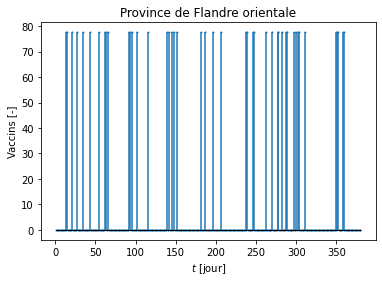

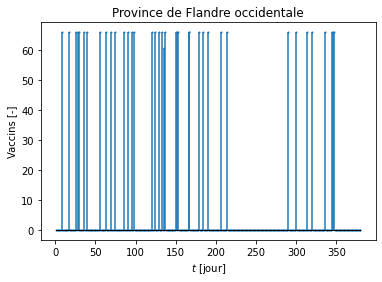

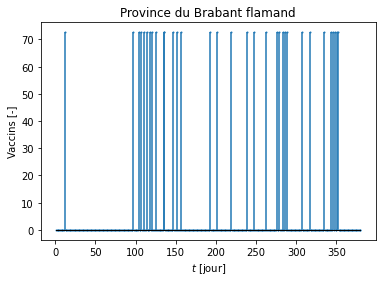

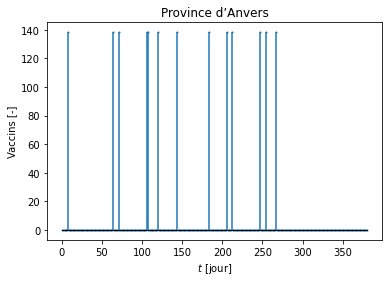

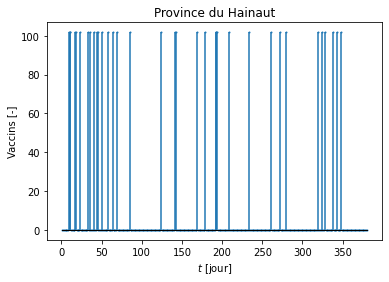

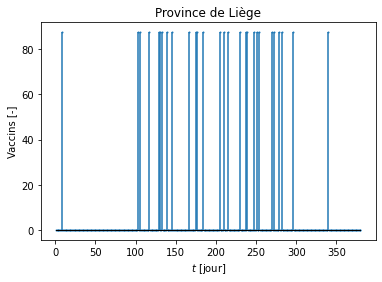

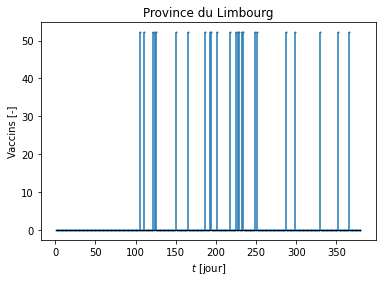

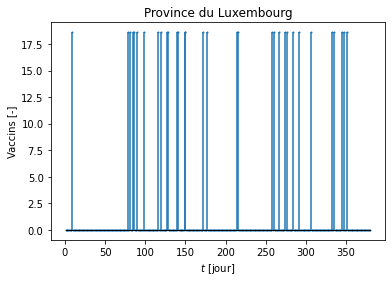

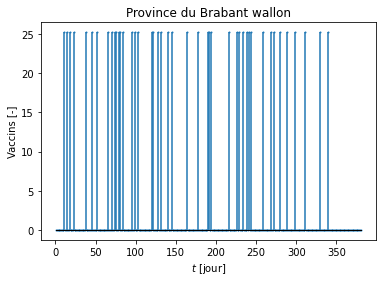

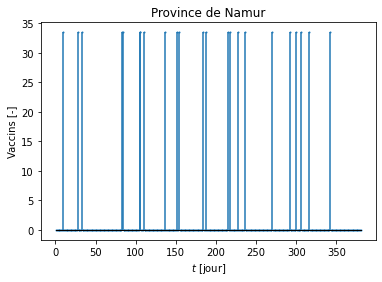

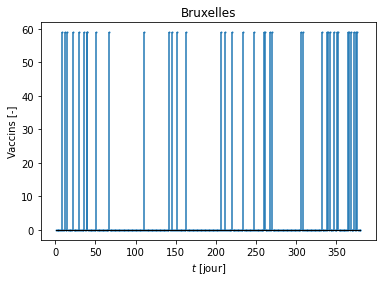

OptimizationStatus.OPTIMAL
f(x,y,z) = 657.7765972315386

valeur initiale de l'objectif : 658.6960938289186


In [188]:
# Vérification
print("\nVariation du nombre de vaccins livrable dans chaque région et par jour pour diminuer d'un mort:\n")
delta_bv = APO_b_v(5e-2)
solve_model(APO_modif='b_v', modif=delta_bv)
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")


Variation du nombre de vaccins stockable dans chaque région et par jour pour diminuer d'un mort:

Delta z = -0.00
beta = 0.001


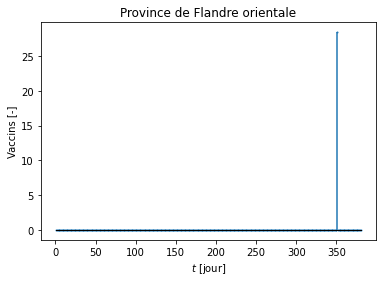

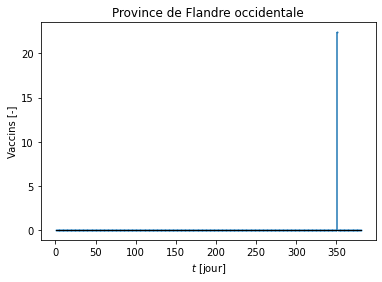

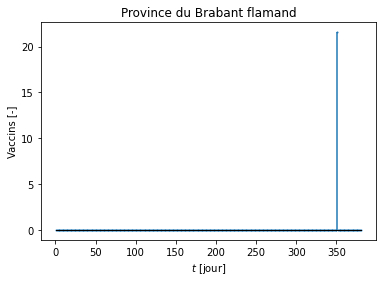

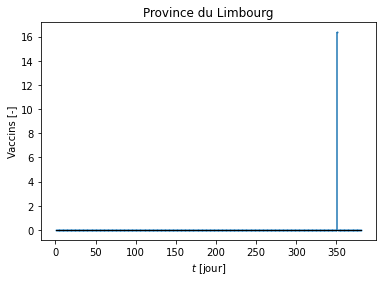

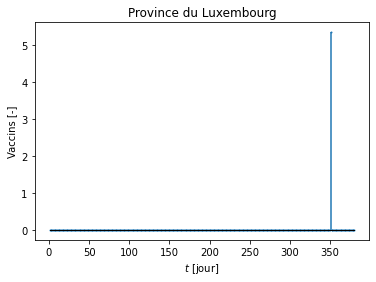

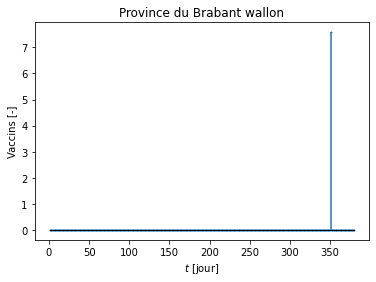

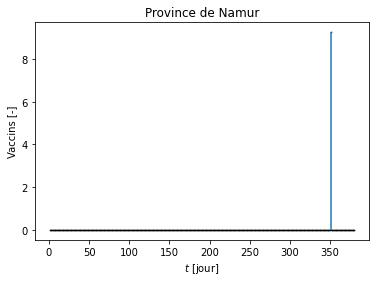

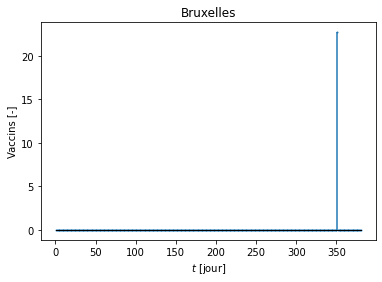

Delta z = -0.00
beta = 0.01


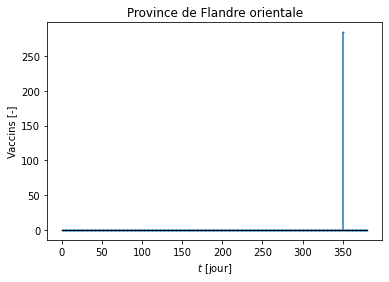

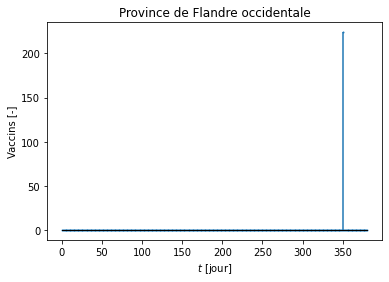

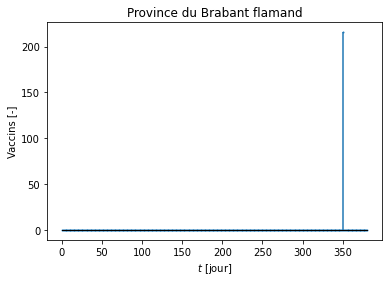

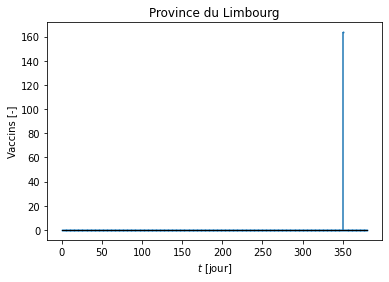

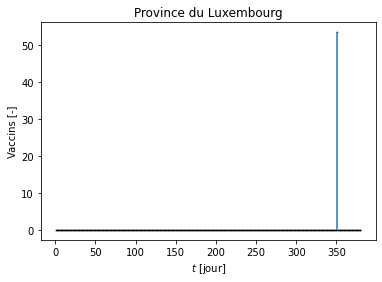

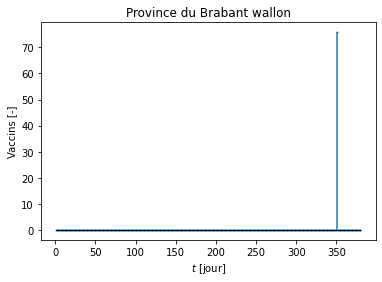

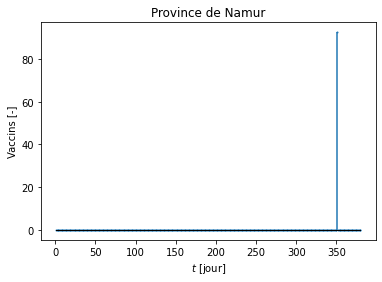

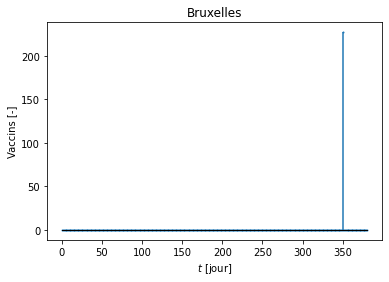

Delta z = -0.00
beta = 0.05


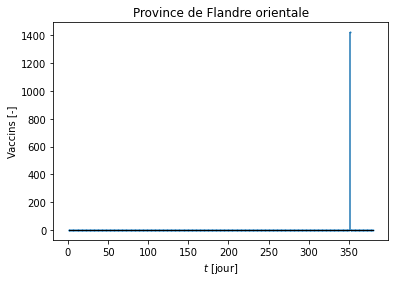

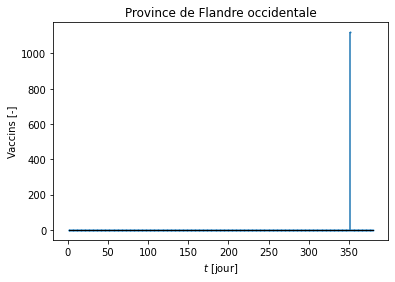

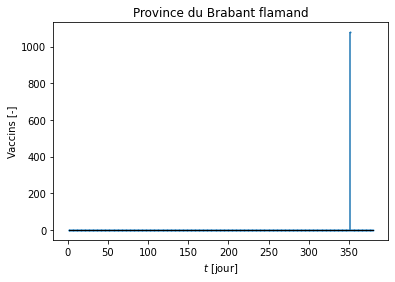

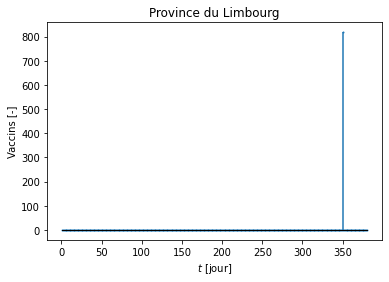

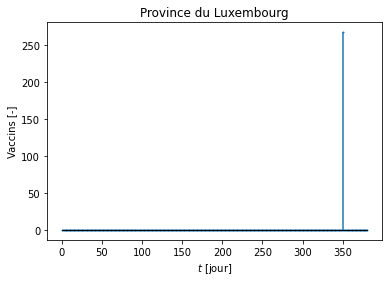

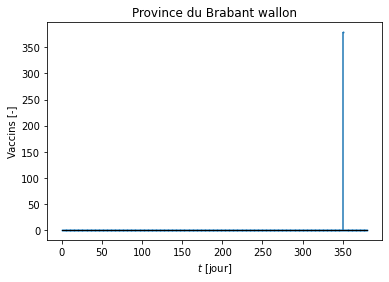

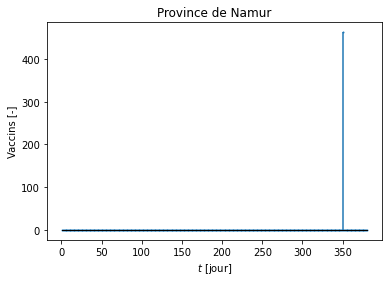

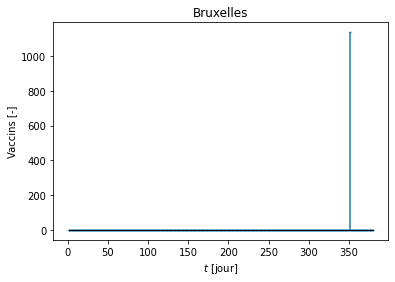

In [189]:
# modification du nombre de vaccins administrables par jour dans chaque centre.
def APO_b_s(beta):
    b3 = [b_s[j] for t in days_2-1 for j in range(n)]
    a3 = y_star[len(b_c)+2*len(b3)+1:len(b_c)+3*len(b3)+1]

    q13_c3, delta_b_s = approx_delta(a3, b3, beta)

    delta_bs = np.array([[delta_b_s[j+t*n].x for t in days_2-1] for j in range(n)])
    delta3 = np.array([delta_b_s[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a3 @ delta3:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bs[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bs[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()
    
    return delta_bs

print("\nVariation du nombre de vaccins stockable dans chaque région et par jour pour diminuer d'un mort:\n")
for beta in [1e-3, 1e-2, 5e-2]:
    APO_b_s(beta)


In [190]:
# Vérification
# solve_model(APO_modif='b_s', modif=APO_b_s(1e-1))
# print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

#### Analyse des résultats

Les graphes tracés ci-dessus correspondent à la modification des différentes limites sur les capacités du problème (livraison, vaccination et stockage) par jour, et ce uniquement pour les régions où cette modification est non-nulle. 

* (1) **Modification de la limite de vaccins livrables $\Delta b_l$**:

Pour les différentes valeurs de $\beta$, seule les provinces d'Anvers et du Hainaut sont concernées par cette modification. D'une part, on observe dans les données qu'il s'agit de $2$ régions où la limite de livrasion est plus faible ($12000$ pour Anvers) que dans d'autres régions ($15600$ pour le Brabant Wallon). D'autre part, en reprenant le graphe circulaire de la question $1.2$ (voir ci-dessous), on constate qu'il s'agit des $2$ régions où l'on vaccine le plus (13.6% et 15.2% respectivement) et donc où la demande est la plus importante.

* (2) **Modification de la limite de vaccins administrables $\Delta b_v$**:
   
Il s'agit ici d'un paramètre assez contraignant du point de vue de l'objectif. En effet, la résolution du modèle avec les données fournies nous indique que la contrainte de coût n'est pas active. Il en est de même pour les contraintes de stockage (comme indiqué plus bas). Il ne reste donc plus que la contrainte sur les vaccins administrables quotidiennement. De ce fait, l'analyse post-optimale nous montre que la modification doit se faire dans toute les régions de façon relativement équitable. On remarque à nouveau que la limite sur la vaccination est plus fortement relâchée dans les provinces d'Anvers et du Hainaut par rapport aux autres provinces. 

* (3) **Modification de la limite vaccins stockables $\Delta b_s$**:

Comme cela a été mentionné plus haut, la limite de stockage ne semble pas jouer un rôle important dans la diminution du nombre de $1$ mort supplémentaire. En effet la contrainte n'est pas active. C'est pourquoi, il n'est pas possible pour une modification faible de cette contrainte de diminuer de $1$ le nombre de mort.

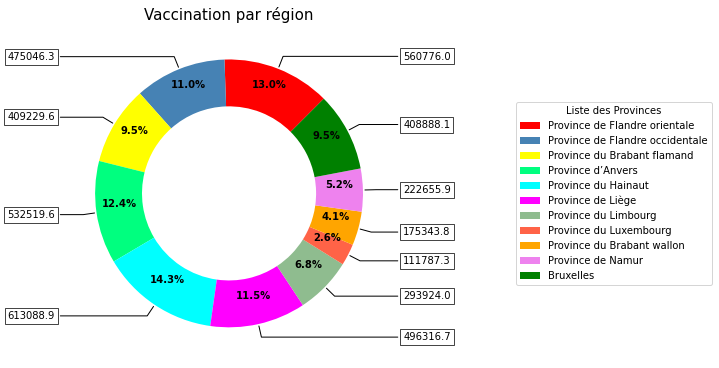

In [191]:
circle(SommeR,province,"Provinces","Vaccination par région")

### Question 1.4

$(a)$ On introduit les variables $(w_1)_{j}^t$ et $(w_2)_{j}^t$ représentant la quantité de vaccins au prix $P_1$ et $P_2$ respectivement, achetée par la province $j$ au jour $t$ dans le stock $Q$. On impose que le nombre de vaccins achetés ne puisse pas dépasser le nombre de vaccins dans $Q$ chaque jour $(6)$ et $(7)$.

De plus, on ajoute le prix d'achat de ces vaccins supplémentaires dans la contrainte de coût total $(1)$. 

Finalement, on ajoute $w_1$ et $w_2$ dans la contrainte concernant les vaccins administrables et stockables chaque jour et dans chaque région $(8)$. On prend la convention que $(w_1)^0 = 0$ et $(w_2)^0 = 0$ pour les mêmes raisons qu'aux points 1.1 et 1.2.

Cela s'écrit donc:

$$\begin{eqnarray*}
\min_{x, y, z, v_s, w_1, w_2}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
(v_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left(c_{tr}\ x_j^t + c_v \sum_{i=1}^{m} y_{ij}^t + c_s z_j^t + P_1\ (w_1)_{j}^t + P_2\ (w_2)_{j}^t \right) &\leq& c_{tot} \tag{1}\\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \tag{2}\\ 
x_j^t &\leq& (b_l)_j^t \tag{3}\\
\sum_{i=1}^{m} y_{ij}^t &\leq& (b_v)_j^t \tag{4}\\
z_j^t &\leq& (b_s)_j^t \tag{5}\\
\sum_{j=1}^{n} (w_1)_{j}^t  & \leq & \frac{1}{2} Q \tag{6}\\
\sum_{j=1}^{n} (w_2)_{j}^t  & \leq & \frac{1}{2} Q \tag{7}\\
x_j^{t-1} + z_j^{t-1} + (w_1)_{j}^{t-1} +(w_2)_{j}^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \tag{8}\\
(v_s)_{ij}^t - y_{ij}^t &\geq& 0\tag{9}\\
(v_s)_{ij}^t - (1-\lambda_{ij}^{t-1})\ (v_s)_{ij}^{t-1} + y_{ij}^{t-1} &=&  0 \tag{10}\\
(v_s)_{ij}^0 &=& \mu_i\ (p_{init})_{ij}\tag{11}\\ 
x^0,\ y^0,\ z^0,\ (w_1)^0,\ (w_2)^0 &=& 0 \tag{12} \\
x,\ y,\ z,\ v_s,\ w_1,\ w_2 &\geq& 0 \tag{13}
\end{eqnarray*}$$

Lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$, $i\in\{1,\ldots,m\}$ et $j\in\{1,\ldots,n\}$.

$(b)$ Pour estimer le nombre de décès une fois la campagne de vaccination terminée jusqu'au temps $S \in [T+1,\infty[$, c'est à dire à partir de $t = T+1$, jusqu'à $t = S$, nous pouvons fixer la fraction de malades $\lambda$ et de morts $\varepsilon$ à celles observées en $t = T$. 

Afin de simuler l'arrêt total de vaccination, nous posons : 
$$\forall t \in [T+1,S]\ : y_{ij}^{t} = 0 \quad \forall i,j$$

Notons également qu'aucune contrainte supplémentaire n'est a priori nécessaire pour les autres variables. En effet, à l'optimum, aucun vaccin ne sera ni livré, ni stocké si ces vaccins ne peuvent être administrés à cause des coûts non-nuls associés à ces opérations.

Si la fenêtre temporelle étudiée après la fin de la campagne de vaccination est infinie, la population susceptible vaccinable au temps $t = \infty$, $(v_s)_{ij}^\infty$, va tendre vers $0$. Dès lors, il suffit de calculer la population décédée jusqu'à un certain temps $N$ tel que pour $\epsilon \ll 1$: 

$$\left|(v_s)_{ij}^{r} - (v_s)_{ij}^{t} \right| < \epsilon \quad \forall r,t > N$$

En d'autres termes, on résout notre modèle jusqu'à un certain temps $N$ pour lequel $(v_s)_{ij}^t$ ne variera quasiment plus $\forall t > N$. Cela permet de ne pas poser une infinité de contraintes sur la variable $y$.

$$%grâce aux coefficients \lambda et \varepsilon$$

### Question 1.5

Nous avons identifié plusieurs hypothèses non-réalistes dans notre modèle. Nous avons décidé d'en développer deux en particulier :

Premièrement, les variables de décisions optimales sont continues alors qu'elles représentent des valeurs entières (vaccins, personnes, livraisons,...). Afin de modifier cela, il faudra implémenter un modèle en variables discrètes. Le modèle actuel nous renseigne sur une borne supérieure sur la valeur réelle de morts, de vaccins, etc.

Deuxièmement, la population dans chaque classe d'âge ne forme qu'un bloc uni. Il serait intéressant de faire des sous-classes selon plusieurs groupes de travailleurs, afin d'identifier ceux à risque : enseignant, personnes dans les centres hospitaliers, métiers de contact, etc. Pouvoir subdiviser les classes d'âge en professions permet de potentiellement ajouter le télé-travail dans l'équation, et donc indirectement le confinement de certaines populations de travailleurs. Ces classes seraient donc moins à risque et pourraient laisser leurs doses à des personnes ayant plus chance de décéder du virus, dû à leurs activités professionnelles et à leur âge.
Pour implémenter cela, il faudrait simplement ajouter des taux d'incidence selon les professions et subdiviser la population de chaque province en classes d'âge, qui elles mêmes seront divisées en professions. On ajoutera également, pour la classe d'âge 0-29, le travail "enfant" et "étudiant".

Pour aller plus loin: 

Ici, bien que les données fournies soient supposées réalistes, nous ne prenons pas en compte les potentielles contaminations entre une personne malade et la population susceptible. Notre modèle est déterministe et manque donc d'un aspect exponentiel, typique des épidémies virales. Afin d'y remédier, il faudrait pouvoir créer un lien entre la catégorie des malades et celle des suceptibles, avec des jours d'incubation, une durée de maladie fixée ainsi qu'un coefficient de risques qu'un malade puisse contaminer une personne susceptible, selon sa classe d'âge.

In [192]:
# OLD VERSION (1); Question 1.1
"""
# Résolution du problème
model_I1 = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x, y, v_s = init_variables(model_I1, m, len(days))

# Objectif
model_I1.objective = minimize(xsum(epsilon_t[i,t] * lambda_t[i,t] * v_s[t][i] for i in range(m) for t in days[1:-1]))

# Contraintes
model_I1 += xsum(c_tr * x) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    model_I1 += x[t] <= b_c[t]
    model_I1 += x[t] <= b_l
    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v

    if t >= 1: 
        model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0
        
    yv_s = v_s[t-1] if t > 1 else mu * pop_init
    for i in range(m):
        model_I1 += v_s[t][i] -  y[t][i] >= 0
        model_I1 += v_s[t][i] - (1 - lambda_t[i,t-1]) * yv_s[i] + y[t-1][i] == 0

model_I1.optimize()
print(f"f(x,y) = {model_I1.objective_value}")
"""

'\n# Résolution du problème\nmodel_I1 = Model(\'centre unique\', sense=MINIMIZE, solver_name=CBC)\n\n# Variables\nx, y, v_s = init_variables(model_I1, m, len(days))\n\n# Objectif\nmodel_I1.objective = minimize(xsum(epsilon_t[i,t] * lambda_t[i,t] * v_s[t][i] for i in range(m) for t in days[1:-1]))\n\n# Contraintes\nmodel_I1 += xsum(c_tr * x) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot\nfor t in days-1:\n    model_I1 += x[t] <= b_c[t]\n    model_I1 += x[t] <= b_l\n    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v\n\n    if t >= 1: \n        model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0\n        \n    yv_s = v_s[t-1] if t > 1 else mu * pop_init\n    for i in range(m):\n        model_I1 += v_s[t][i] -  y[t][i] >= 0\n        model_I1 += v_s[t][i] - (1 - lambda_t[i,t-1]) * yv_s[i] + y[t-1][i] == 0\n\nmodel_I1.optimize()\nprint(f"f(x,y) = {model_I1.objective_value}")\n'

In [193]:
# OLD VERSION (2); Question 1.1
"""
model_I1 = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x, y, v_s = init_variables(model_I1, m, len(days))

# Objectif
model_I1.objective = minimize(xsum(epsilon_t[i,t] * lambda_t[i,t] * v_s[t][i] for i in range(m) for t in days-1))

# Contraintes
model_I1 += xsum(c_tr * x[t] for t in days-1) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    model_I1 += x[t] <= b_c[t]
    model_I1 += x[t] <= b_l
    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v
    model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0
        
    for i in range(m):
        model_I1 += v_s[t][i] -  y[t][i] >= 0
        model_I1 += v_s[t][i] - (1 - lambda_t[i,t-1]) * v_s[t-1][i] + y[t-1][i] == 0
        
# Conditions initiales  
model_I1 += x[-1] == 0
for i in range(m):
    model_I1 += y[-1][i] == 0
    model_I1 += v_s[-1][i] - mu[i] * pop_init[i] == 0

model_I1.optimize()
print(f"f(x,y) = {model_I1.objective_value}")
"""

'\nmodel_I1 = Model(\'centre unique\', sense=MINIMIZE, solver_name=CBC)\n\n# Variables\nx, y, v_s = init_variables(model_I1, m, len(days))\n\n# Objectif\nmodel_I1.objective = minimize(xsum(epsilon_t[i,t] * lambda_t[i,t] * v_s[t][i] for i in range(m) for t in days-1))\n\n# Contraintes\nmodel_I1 += xsum(c_tr * x[t] for t in days-1) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot\nfor t in days-1:\n    model_I1 += x[t] <= b_c[t]\n    model_I1 += x[t] <= b_l\n    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v\n    model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0\n        \n    for i in range(m):\n        model_I1 += v_s[t][i] -  y[t][i] >= 0\n        model_I1 += v_s[t][i] - (1 - lambda_t[i,t-1]) * v_s[t-1][i] + y[t-1][i] == 0\n        \n# Conditions initiales  \nmodel_I1 += x[-1] == 0\nfor i in range(m):\n    model_I1 += y[-1][i] == 0\n    model_I1 += v_s[-1][i] - mu[i] * pop_init[i] == 0\n\nmodel_I1.optimize()\nprint(f"f(x,y) = {model_I1.objective_value}")\n'

In [194]:
# OLD VERSION ; Question 1.2
# Objectif
"""
model_I2.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i][j] * v_s[t-1][j][i]
                                for j in range(n) for i in range(m) for t in days_2[1:-1]))

# Contrainte sur le coût total
model_I2 +=  xsum(c_tr[j] * x[t][j] for j in range(n) for t in days_2-1) \
         + xsum(c_v[j] * y[t][j][i] for i in range(m) for j in range(n) for t in days_2-1) \
         + xsum(c_s[j] * z[t][j] for j in range(n) for t in days_2-1) <= c_tot

# Contrainte sur la quantité de vaccins livrables au temps t à tous les centres
for t in days_2-1:   
    model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t]
        
# Contrainte sur le nombre de vaccins livrables au centre j et au temps t    
for t in days_2-1:       
    for j in range(n):                     
        model_I2 += x[t][j] <= b_l[j]
        
# Contrainte sur le nombre de vaccins administrables au temps t    
for t in days_2-1:       
    for j in range(n):                     
        model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v[j]
        
# Contrainte sur le nombre de vaccins stockables au centre j et au temps t    
for t in days_2-1:       
    for j in range(n):                     
        model_I2 += z[t][j] <= b_s[j]
        
# On ne peut stocker ou administrer aucun vaccin le premier jour.
for j in range(n):   
    # Puisque z >= 0 et y >= 0 -> z[0] = 0 et y[0] = 0 pour tout i,j 
    model_I2 += xsum(y[0][j][i] for i in range(m)) + z[0][j] == 0        
    
# Contrainte physique sur la quantité de vaccins disponibles et stockables au temps t     
for t in days_2-1:
    for j in range(n):
        if t >= 1: 
            model_I2 += x[t-1][j] + z[t-1][j] - xsum(y[t][j][i] for i in range(m)) - z[t][j] >= 0
        
# Contrainte sur le nombre de personnes vaccinables au temps t        
for t in days_2-1:          
    yy = y[t-1] if t >= 1 else np.zeros_like(y[0])
    for j in range(n): 
        yv_s = v_s[t-1][j] if t >= 1 else mu * pop_init[j]
        for i in range(m):
            model_I2 += mu[i] * yv_s[i] - y[t][j][i] >= 0
            model_I2 += v_s[t][j][i] - (1 - lambda_t[t][i][j]) * yv_s[i] + yy[j][i] == 0
            
model_I2.optimize()
print(f"f(x,y,z) = {model_I2.objective_value}")
"""

'\nmodel_I2.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i][j] * v_s[t-1][j][i]\n                                for j in range(n) for i in range(m) for t in days_2[1:-1]))\n\n# Contrainte sur le coût total\nmodel_I2 +=  xsum(c_tr[j] * x[t][j] for j in range(n) for t in days_2-1)          + xsum(c_v[j] * y[t][j][i] for i in range(m) for j in range(n) for t in days_2-1)          + xsum(c_s[j] * z[t][j] for j in range(n) for t in days_2-1) <= c_tot\n\n# Contrainte sur la quantité de vaccins livrables au temps t à tous les centres\nfor t in days_2-1:   \n    model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t]\n        \n# Contrainte sur le nombre de vaccins livrables au centre j et au temps t    \nfor t in days_2-1:       \n    for j in range(n):                     \n        model_I2 += x[t][j] <= b_l[j]\n        \n# Contrainte sur le nombre de vaccins administrables au temps t    \nfor t in days_2-1:       \n    for j in range(n):                     \n        model_I2 += x